# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 7.5.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [9]:
!pip install folium

In [10]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [11]:
import numpy as np
%pylab inline
import pandas as pd  # your favorite data package
%matplotlib inline
import matplotlib.pyplot as plt  # your favorite visualization package
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [12]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
!wget  -O 'train.csv' -q 'https://www.dropbox.com/scl/fi/39wfup835rfwzxcecau9z/train.csv?rlkey=d2dt5g0uxiu9w73af59x99zh3&st=qbpfosga&dl=0'
df = pd.read_csv('train.csv')
df.shape

(1458644, 11)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [13]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.drop(labels=['dropoff_datetime'], axis=1, inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df


id  vendor_id     pickup_datetime  passenger_count  \
0        id2875421          2 2016-03-14 17:24:55                1   
1        id2377394          1 2016-06-12 00:43:35                1   
2        id3858529          2 2016-01-19 11:35:24                1   
3        id3504673          2 2016-04-06 19:32:31                1   
4        id2181028          2 2016-03-26 13:30:55                1   
...            ...        ...                 ...              ...   
1458639  id2376096          2 2016-04-08 13:31:04                4   
1458640  id1049543          1 2016-01-10 07:35:15                1   
1458641  id2304944          2 2016-04-22 06:57:41                1   
1458642  id2714485          1 2016-01-05 15:56:26                1   
1458643  id1209952          1 2016-04-05 14:44:25                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
0              -73.982155        40.767937         -73.964630   
1              -73.980415        40.738564         -73.999481   
2              -73.979027        40.763939         -74.005333   
3              -74.010040        40.719971         -74.012268   
4              -73.973053        40.793209         -73.972923   
...                   ...              ...                ...   
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude store_and_fwd_flag  trip_duration  
0               40.765602                  N            455  
1               40.731152                  N            663  
2               40.710087                  N           2124  
3               40.706718                  N            429  
4               40.782520                  N            435  
...                   ...                ...            ...  
1458639         40.740170                  N            778  
1458640         40.796547                  N            655  
1458641         40.707371                  N            764  
1458642         40.757107                  N            373  
1458643         40.790585                  N            198  

[1458644 rows x 10 columns]

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

In [14]:
df['trip_duration'].max()

3526282

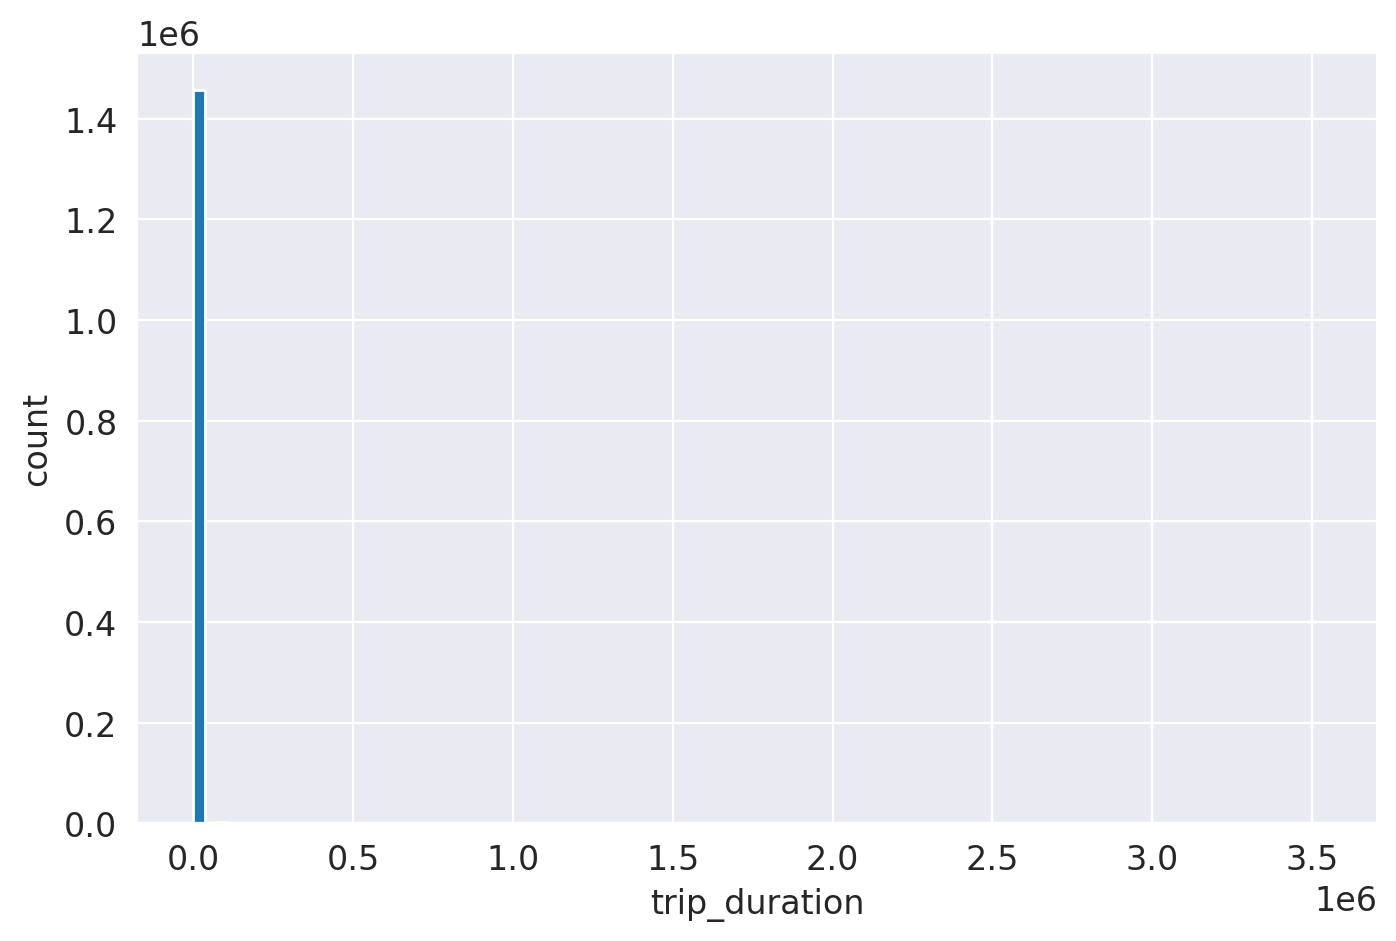

In [15]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y_tr = df['trip_duration']
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Толщина большого столбца примерно равна 1/15 от деления 0-500000. Следовательно, длина поездки основной массы объектов лежит в диапазоне от 0 до 500000/15 = примерно 33333 секунды. Тем не менее на оси trip_duration есть и бОльшие деления (вплоть до 3500000+ секунд), а значит там есть маленькие столбцы (целевая переменная принимает и такие значения). Но высота этих столбцов очень мала по сравнению с большим столбцом - это неудивительно, ведь к большому столбцу относится примерно 1450000 объектов, а всего у нас, судя по df.shape 1458644 объектов. По итогу можно сказать, что имеет место большой разброс целевой переменной. Гистограммма не дает понять в полной мере количество объектов, для которых целевая переменная принимает большие значения.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

При использовании RMSE модель будет сильно штрафовать за относительно (длины поездки) небольшую ошибку при предсказании длины для больших поездок (например, если длина поездки 2.000.000, а она выдала 2.100.000), следовательно, модель будет стараться минимизировать RMSE засчет этих объектов, следовательно, она будет хорошо обучена для предсказания длины больших поездок, но плохо для предсказания длины коротких поездок (то есть будет плохо работать на последних объектах).

При использовании RMSLE, напротив, модель будет учитывать длину поездки при подсчете ошибки засчет использования натурального логарифма (при RMSLE $\sqrt{(\ln(2100000 + 1)-\ln(2000000 + 1))^2}≈0.05$, а при RMSE $\sqrt{(2100000 - 2000000)^2}≈316.23$) и не так сильно штрафовать за относительно (длины поездки) небольшую ошибку. Таким образом, объекты с большой целевой переменной (возможно, это выбросы) не будут отличаться от объектов с небольшой/средней целевой переменной для функционала ошибки, следовательно, почти все объекты будут считаться норм данными, и, как следствие, модель хорошо обучится предсказывать целевую переменную для всех объектов.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ



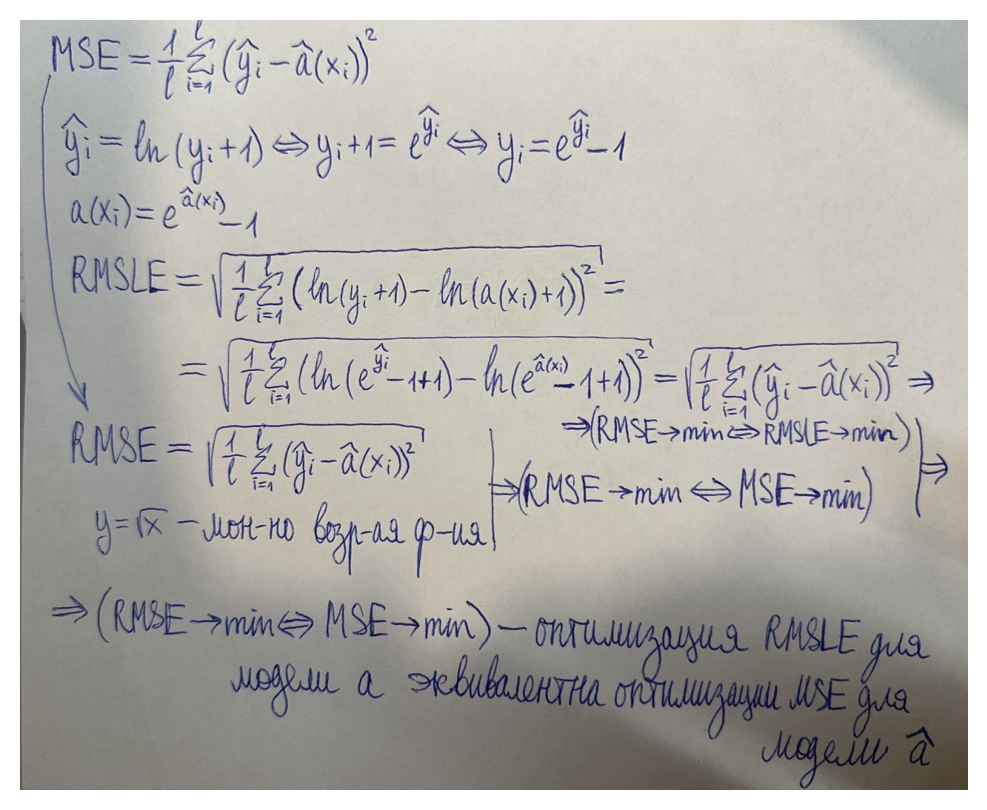

In [16]:
from PIL import Image

image_path = '/content/equivalent_optimization.jpg'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

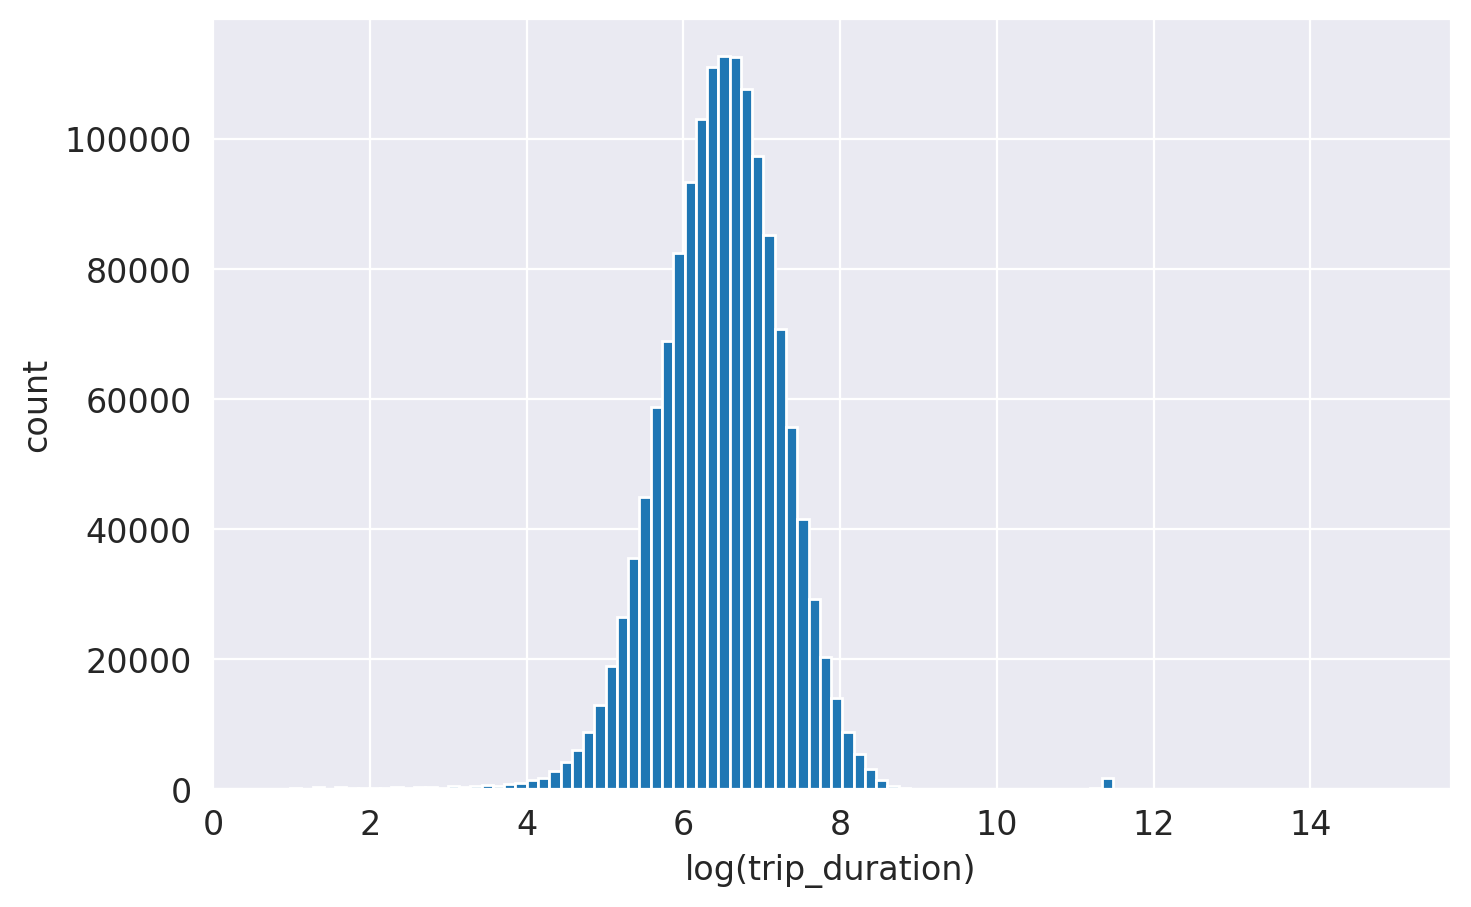

In [17]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
plt.hist(df['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('count')
plt.show()

In [18]:
df.drop('trip_duration', axis=1, inplace=True)
df

id  vendor_id     pickup_datetime  passenger_count  \
0        id2875421          2 2016-03-14 17:24:55                1   
1        id2377394          1 2016-06-12 00:43:35                1   
2        id3858529          2 2016-01-19 11:35:24                1   
3        id3504673          2 2016-04-06 19:32:31                1   
4        id2181028          2 2016-03-26 13:30:55                1   
...            ...        ...                 ...              ...   
1458639  id2376096          2 2016-04-08 13:31:04                4   
1458640  id1049543          1 2016-01-10 07:35:15                1   
1458641  id2304944          2 2016-04-22 06:57:41                1   
1458642  id2714485          1 2016-01-05 15:56:26                1   
1458643  id1209952          1 2016-04-05 14:44:25                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
0              -73.982155        40.767937         -73.964630   
1              -73.980415        40.738564         -73.999481   
2              -73.979027        40.763939         -74.005333   
3              -74.010040        40.719971         -74.012268   
4              -73.973053        40.793209         -73.972923   
...                   ...              ...                ...   
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude store_and_fwd_flag  log_trip_duration  
0               40.765602                  N           6.122493  
1               40.731152                  N           6.498282  
2               40.710087                  N           7.661527  
3               40.706718                  N           6.063785  
4               40.782520                  N           6.077642  
...                   ...                ...                ...  
1458639         40.740170                  N           6.658011  
1458640         40.796547                  N           6.486161  
1458641         40.707371                  N           6.639876  
1458642         40.757107                  N           5.924256  
1458643         40.790585                  N           5.293305  

[1458644 rows x 10 columns]

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [19]:
from sklearn.metrics import make_scorer
def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    error = (log1p_y_true - log1p_y_pred) ** 2
    return np.sqrt(np.mean(error))
    #raise NotImplementedError
rmsle_scorer = make_scorer(
    rmsle,
    greater_is_better=False
)
rmsle_best_const = rmsle(df['log_trip_duration'], np.mean(df['log_trip_duration']))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

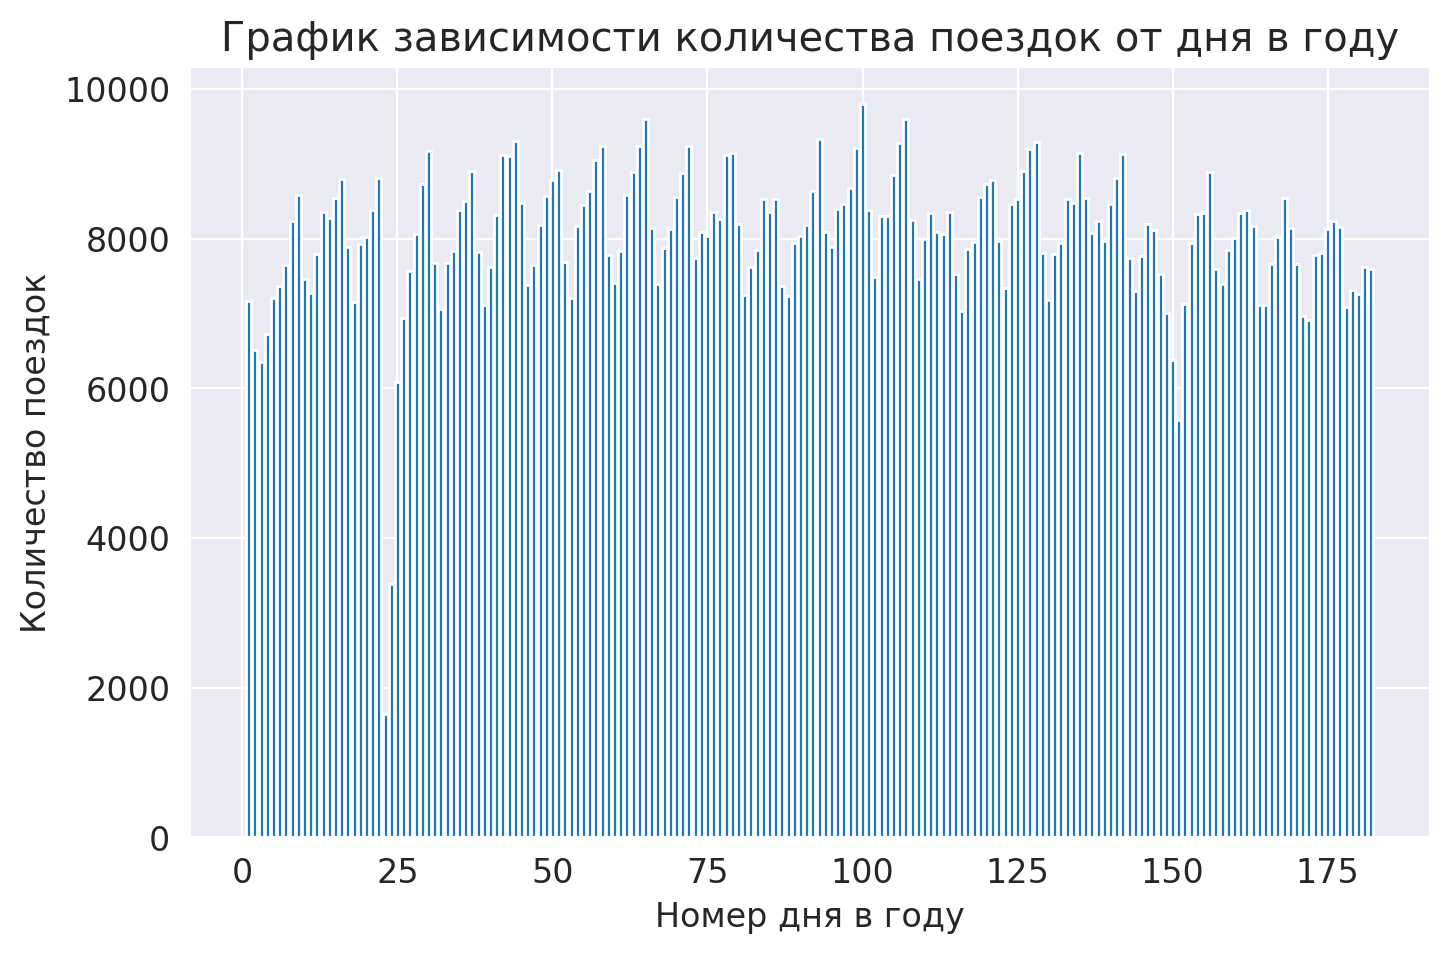

In [20]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['pickup_datetime_dayofyear'] = df['pickup_datetime'].dt.dayofyear
ser_dayofyear = df.groupby('pickup_datetime_dayofyear')['id'].count()
x = ser_dayofyear.index
y = ser_dayofyear
plt.bar(x, y)
plt.xlabel('Номер дня в году')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок от дня в году')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [21]:
ser_dayofyear.idxmin()

23

In [22]:
ser_dayofyear.drop(labels=[ser_dayofyear.idxmin()], inplace=True)
ser_dayofyear.idxmin()

24

In [23]:
ser_dayofyear.drop(labels=[ser_dayofyear.idxmin()], inplace=True)
ser_dayofyear.idxmin()

151

Таким образом, можно выделить 2 периода с аномально маленькими количествами поездок: 23.01.2016-25.01.2016 и 29.05.2016-30.05.2016 (151 день в 2016 году - 30 мая). В первый период на Нью-Йорк обрушилась снежная буря, из-за которой в городе запретили автомобильное движение (источник: https://www.rbc.ru/society/23/01/2016/56a3e5799a79474d3a9a9598). Во второй период произошёл компьютерный сбой в аэропорте имени Джона Кэннеди, в результате которого упало количество поездок туда и по городу в целом (источник: https://ria.ru/20160530/1440615426.html).

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

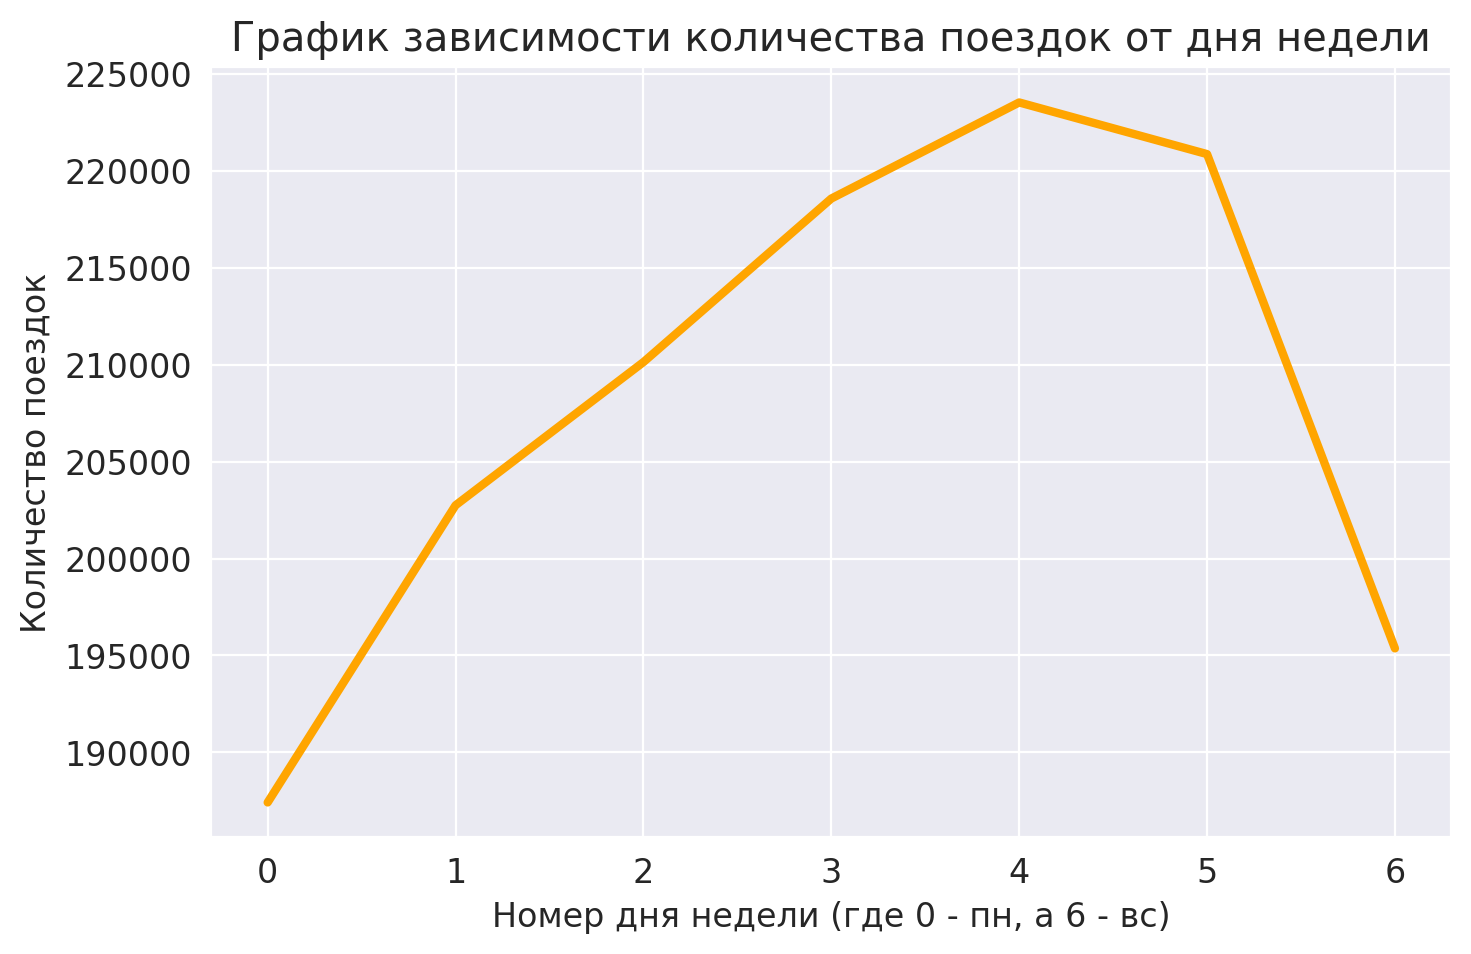

In [24]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['pickup_datetime_dayofweek'] = df['pickup_datetime'].dt.dayofweek
ser_dayofweek = df.groupby('pickup_datetime_dayofweek')['id'].count()
x = ser_dayofweek.index
y = ser_dayofweek
plt.plot(x, y, color='orange', linewidth=3)
plt.xlabel('Номер дня недели (где 0 - пн, а 6 - вс)')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок от дня недели')
plt.show()

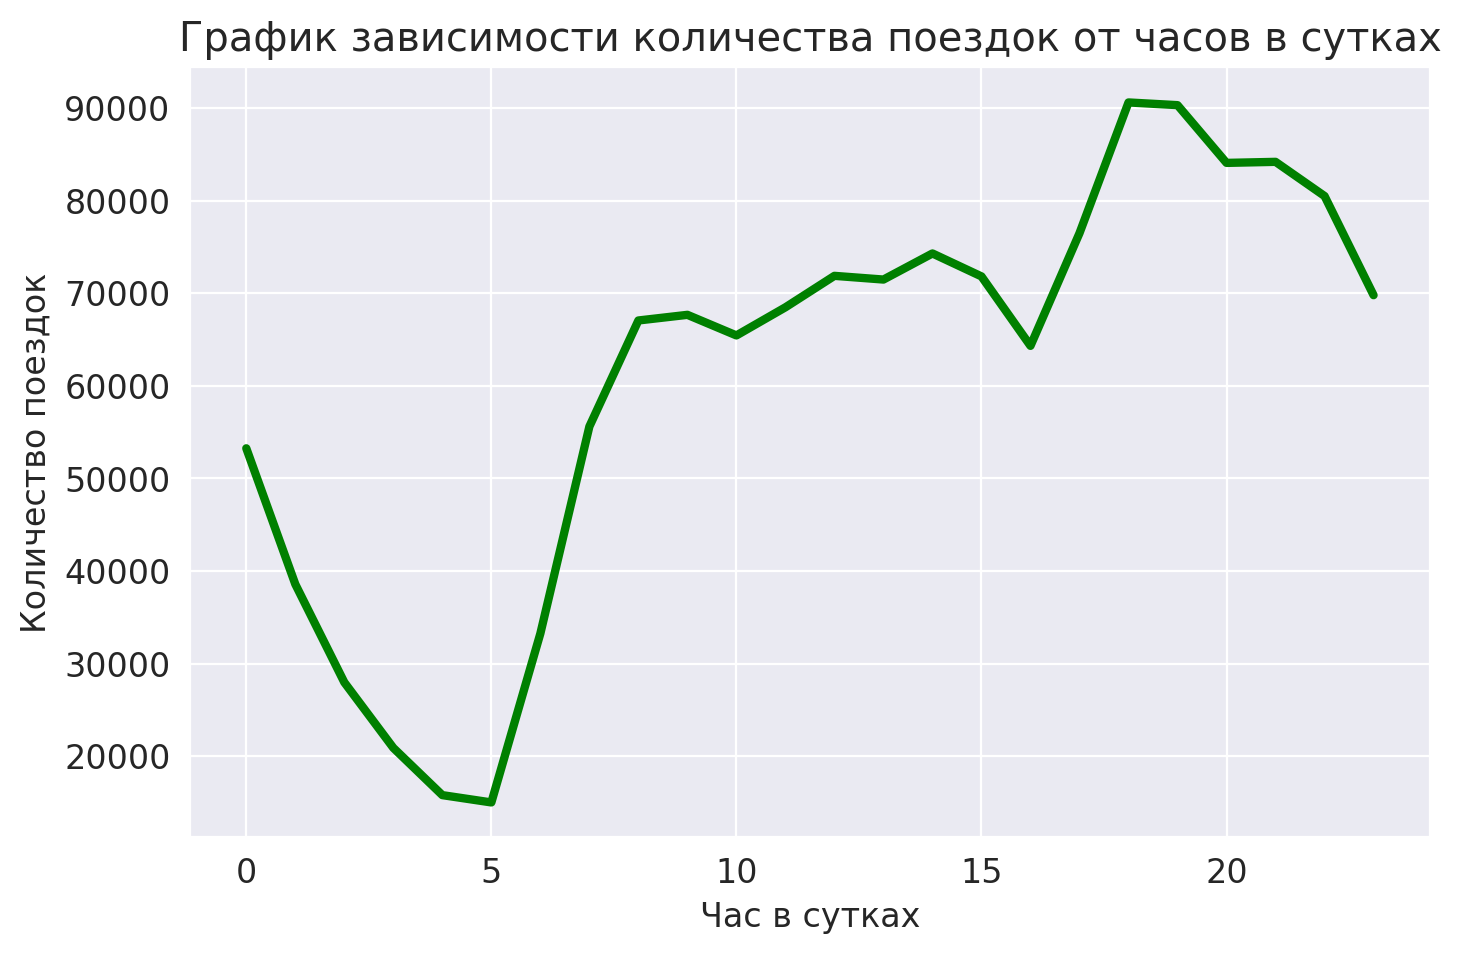

In [25]:
df['pickup_datetime_hour'] = df['pickup_datetime'].dt.hour
ser_hour = df.groupby('pickup_datetime_hour')['id'].count()
x = ser_hour.index
y = ser_hour
plt.plot(x, y, color='green', linewidth=3)
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок от часов в сутках')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

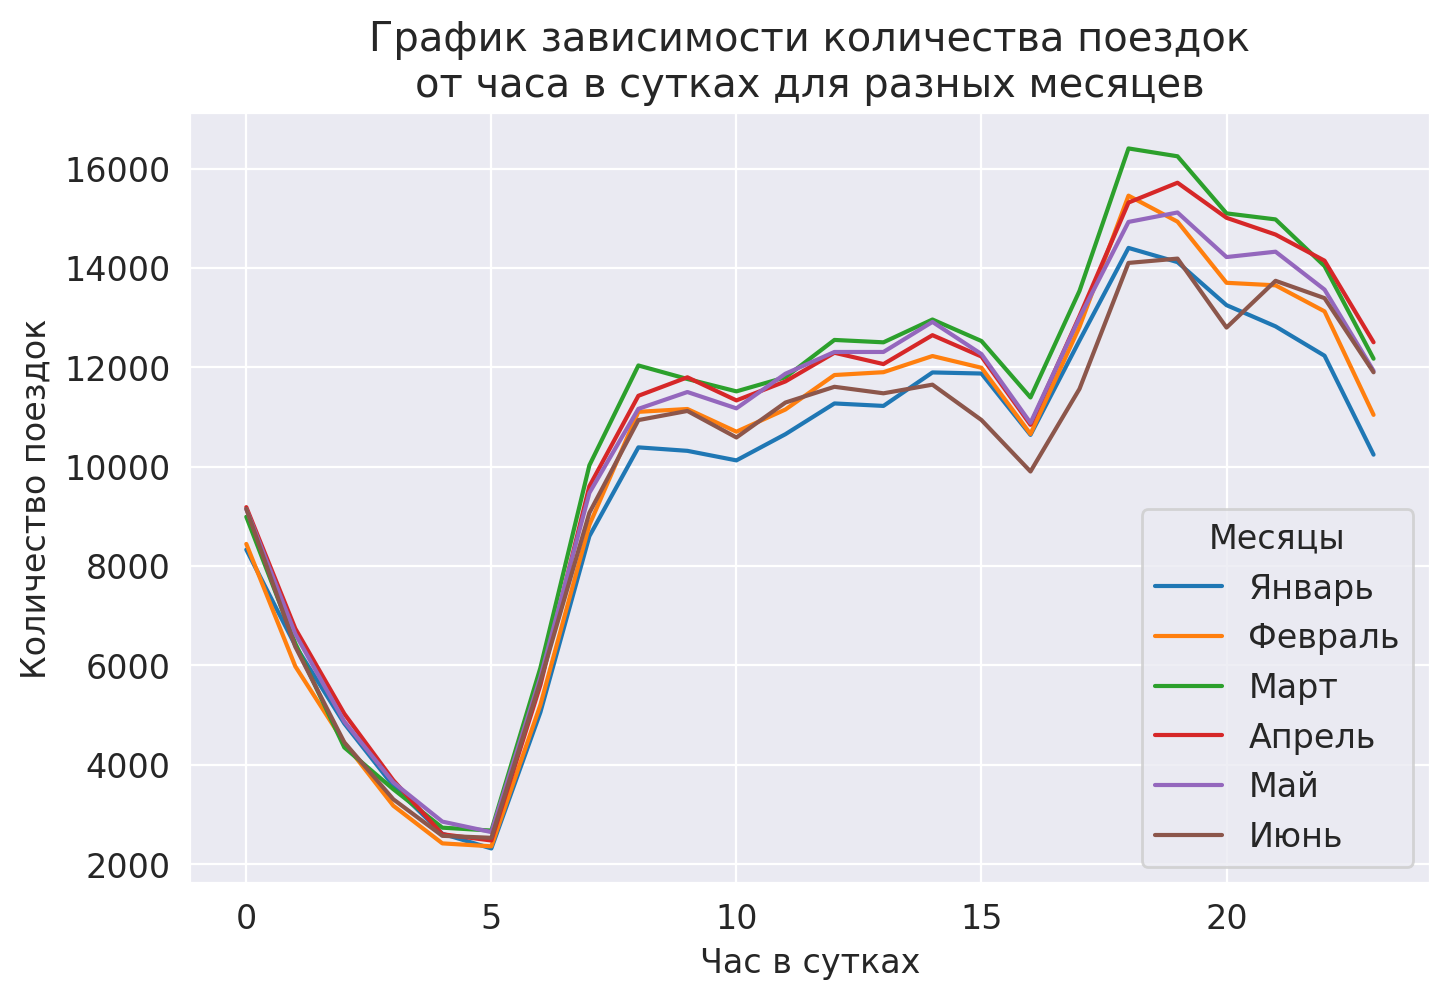

In [26]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['pickup_datetime_month'] = df['pickup_datetime'].dt.month
month_list = ['', 'Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

for i in range(1, 13):
  ser_month = df[df['pickup_datetime_month'] == i].groupby('pickup_datetime_hour')['id'].count()
  if ser_month.shape[0] != 0:
    x = ser_month.index
    y = ser_month
    plt.plot(x, y, label=month_list[i])
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок\nот часа в сутках для разных месяцев')
plt.legend(title='Месяцы', loc='lower right')
plt.show()

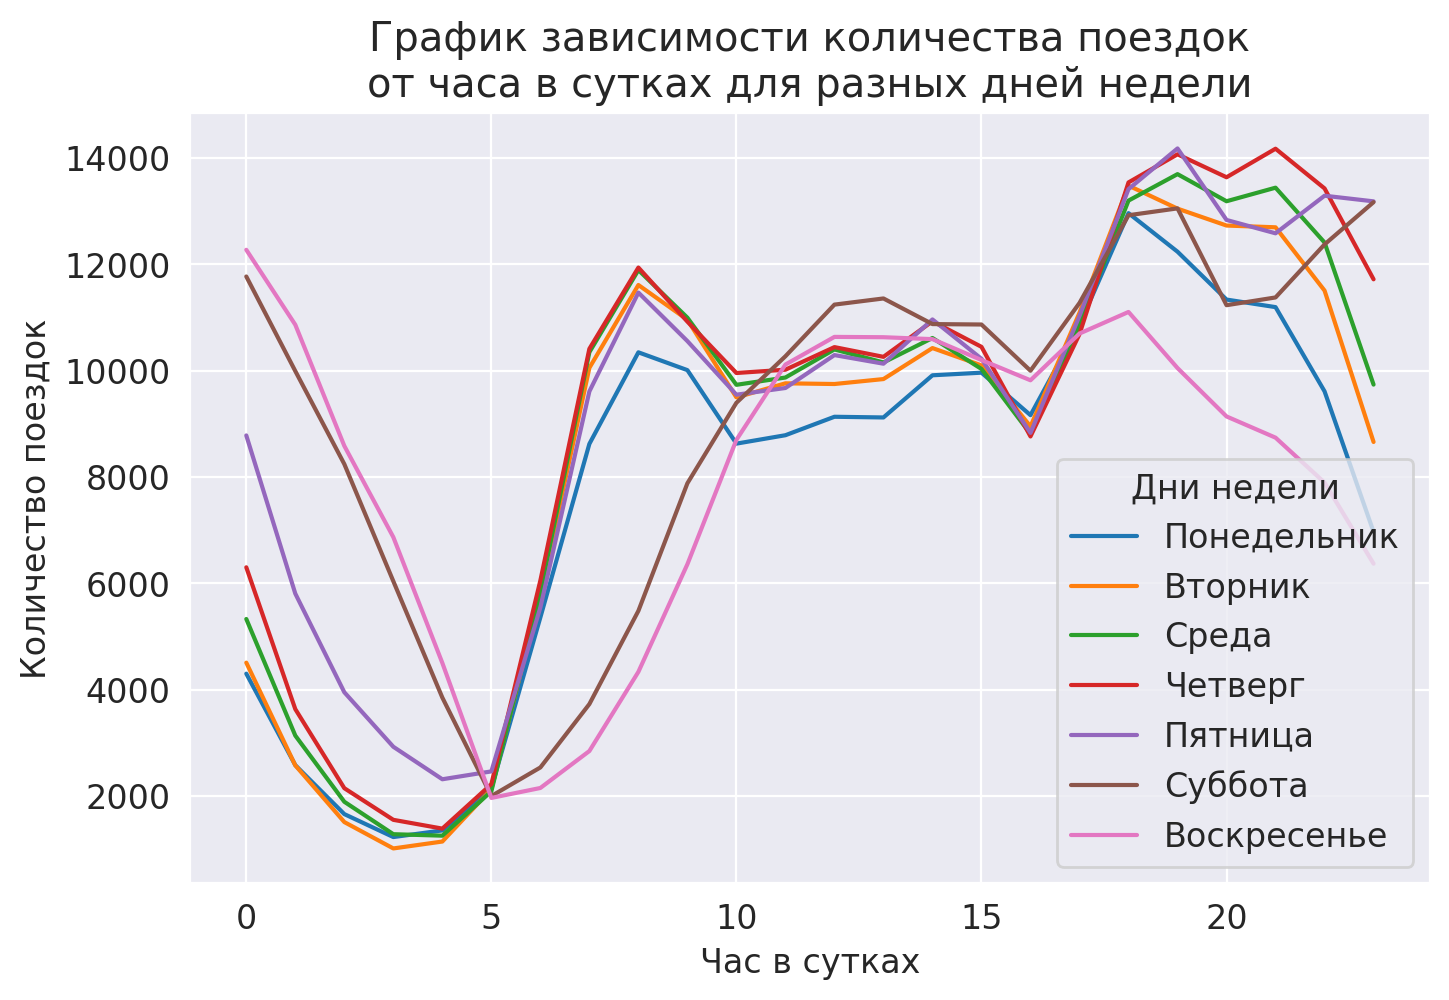

In [27]:
weekday_list = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
for i in range(7):
  ser_weekday = df[df['pickup_datetime_dayofweek'] == i].groupby('pickup_datetime_hour')['id'].count()
  if ser_weekday.shape[0] != 0:
    x = ser_weekday.index
    y = ser_weekday
    plt.plot(x, y, label=weekday_list[i])
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.title('График зависимости количества поездок\nот часа в сутках для разных дней недели')
plt.legend(title='Дни недели', loc='lower right')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Что касается графика зависимости количества поездок от часа в сутках для разных месяцев, можно заметить, что в зависимости от месяца количество поездок отличается минимально (в ночные и утренние часы - примерно с 0 до 8 утра отличия вообще незаметны). Также видно, что примерно с 8 утра и до конца суток количество поездок, совершаемых в весенние месяцы больше, чем в зимние - это можно объяснить увеличением светового дня.

Что касается графика зависимости количества поездок от часа в сутках для разных дней недели, количество поездок в зависимости от часа в сутках в выходные дни примерно совпадает, кроме вечерних часов (приблизительно с 17 и до конца суток) - это можно объяснить тем, что вечером в сб люди едут на большее количество ивентов, чем в вс, поскольку в вс они понимают, что на следующий день им работу (то есть могут позволить себе вернуться поздно ночью с сб на вс, но не поздно ночью с вс на пн). В будние дни также количество поездок от часа в сутках примерно совпадает, кроме вечерних часов: примерно с 21 и до конца суток во все будние дни, кроме пт, начинается стремительное падение количества поездок, в то время как в пт количество поездок в этом временном интервале остаётся на прежнем относительно высоком уровне. Это можно объяснить тем, что в пт люди едут вечером веселиться на различные ивенты, так как могут себе это позволить, ведь на следующий день им не надо идти на работу (в отличие от остальных будних дней).

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [28]:
 #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

df = df.drop(columns=['id', 'pickup_datetime_dayofyear', 'pickup_datetime_dayofweek', 'pickup_datetime_hour', 'pickup_datetime_month'])

In [29]:
y = df['log_trip_duration']
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

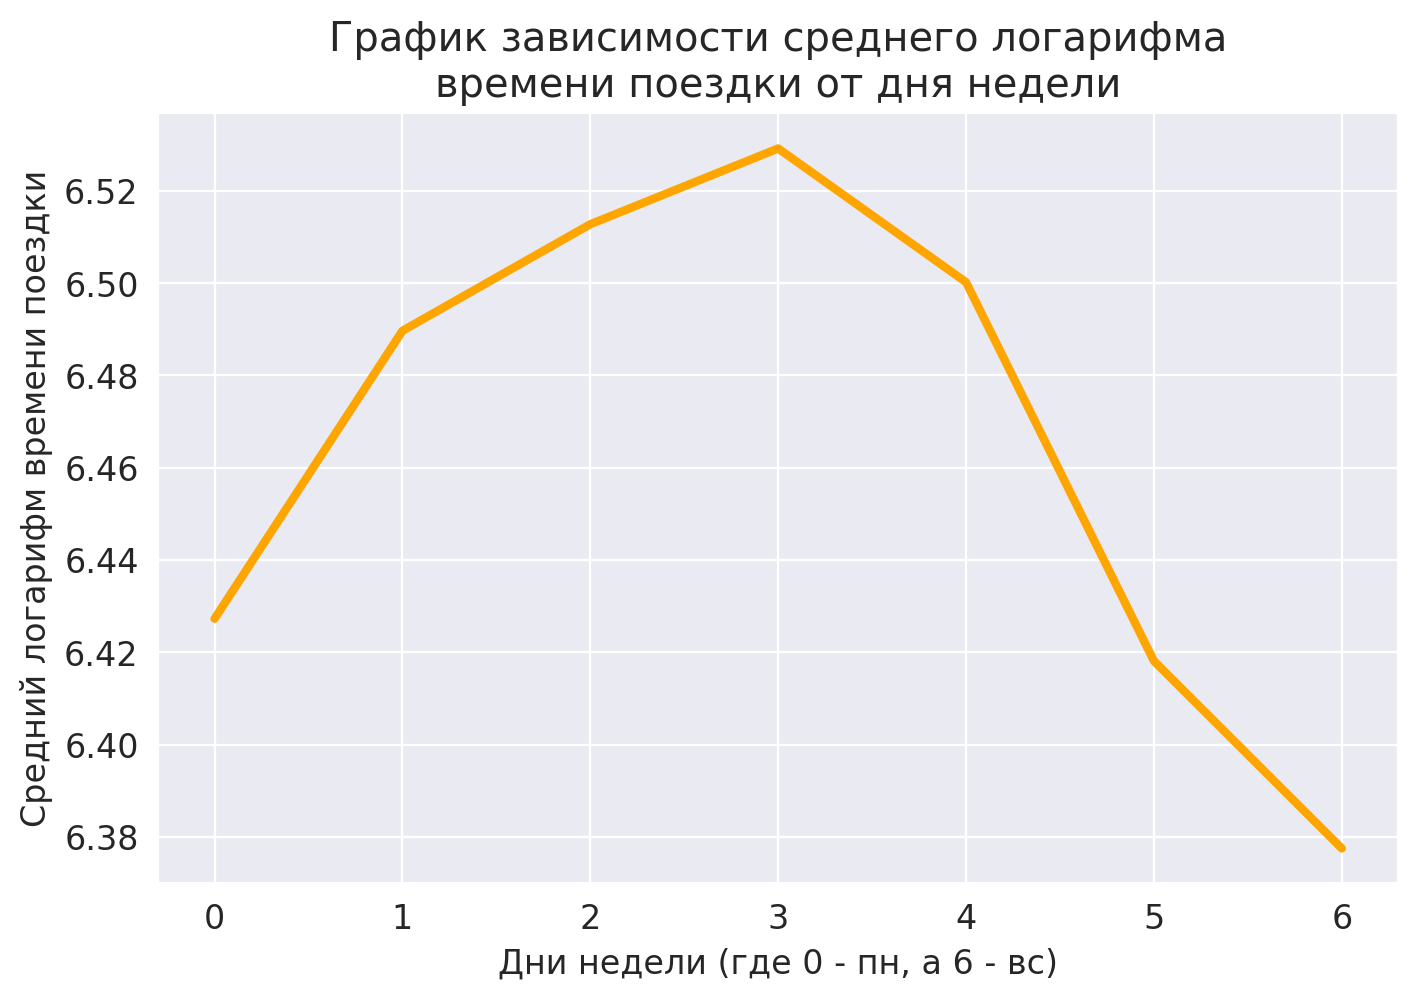

In [30]:
X_train['day_of_week'] = X_train['pickup_datetime'].dt.dayofweek
ser_weekdays = X_train.groupby('day_of_week')['log_trip_duration'].mean()
x = ser_weekdays.index
y = ser_weekdays
plt.plot(x, y, color='orange', linewidth=3)
plt.xlabel('Дни недели (где 0 - пн, а 6 - вс)')
plt.ylabel('Средний логарифм времени поездки')
plt.title('График зависимости среднего логарифма\nвремени поездки от дня недели')
plt.show()

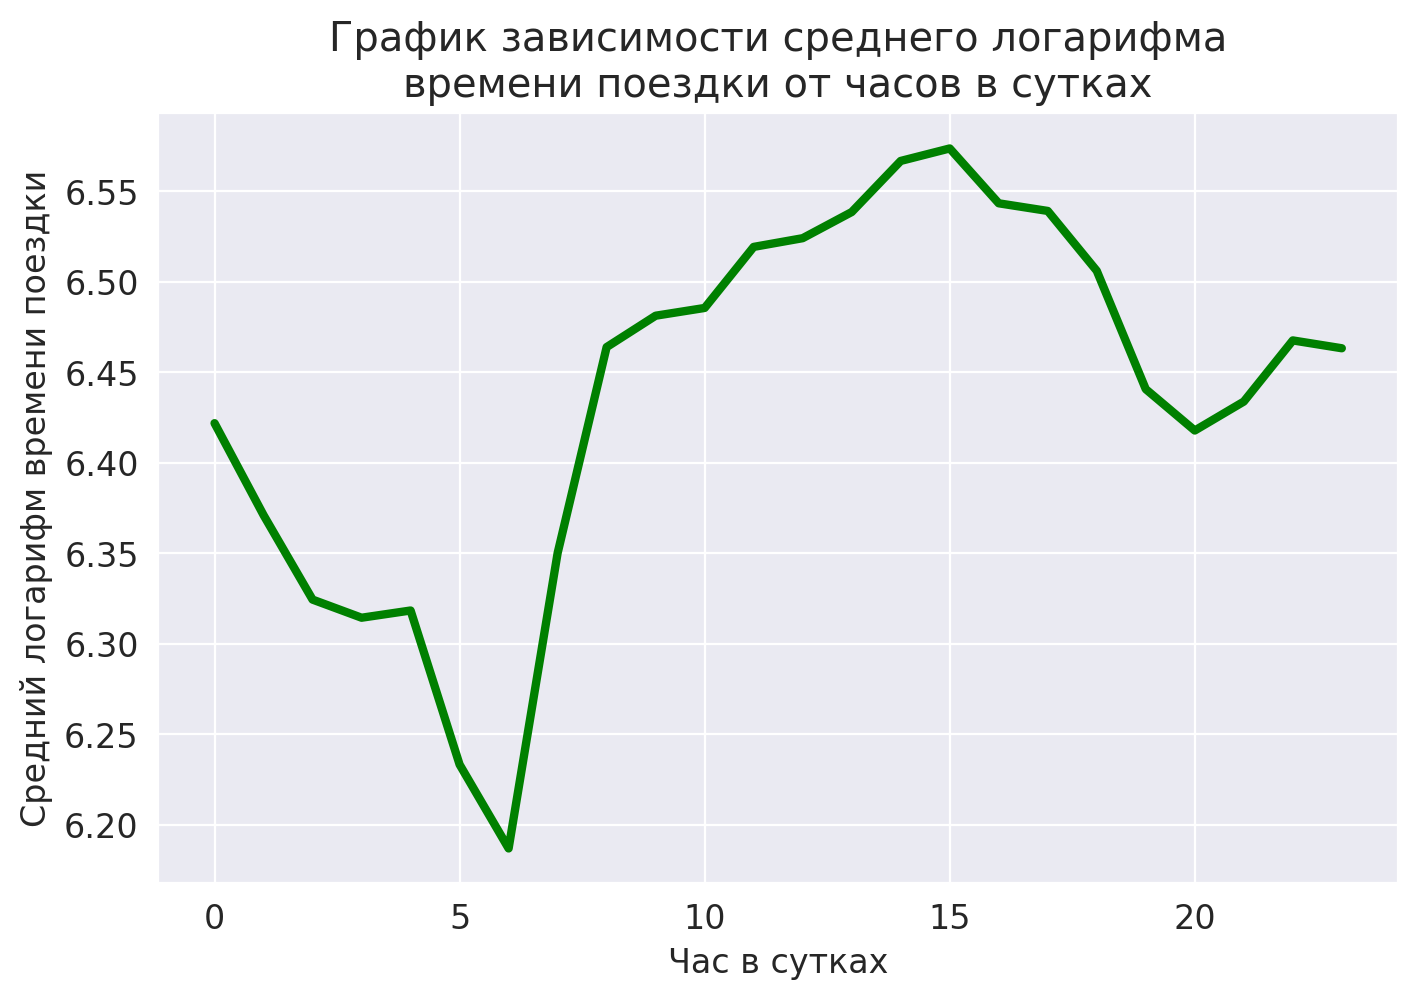

In [31]:
X_train['hour'] = X_train['pickup_datetime'].dt.hour
ser_hours = X_train.groupby('hour')['log_trip_duration'].mean()
x = ser_hours.index
y = ser_hours
plt.plot(x, y, color='green', linewidth=3)
plt.xlabel('Час в сутках')
plt.ylabel('Средний логарифм времени поездки')
plt.title('График зависимости среднего логарифма\nвремени поездки от часов в сутках')
plt.show()

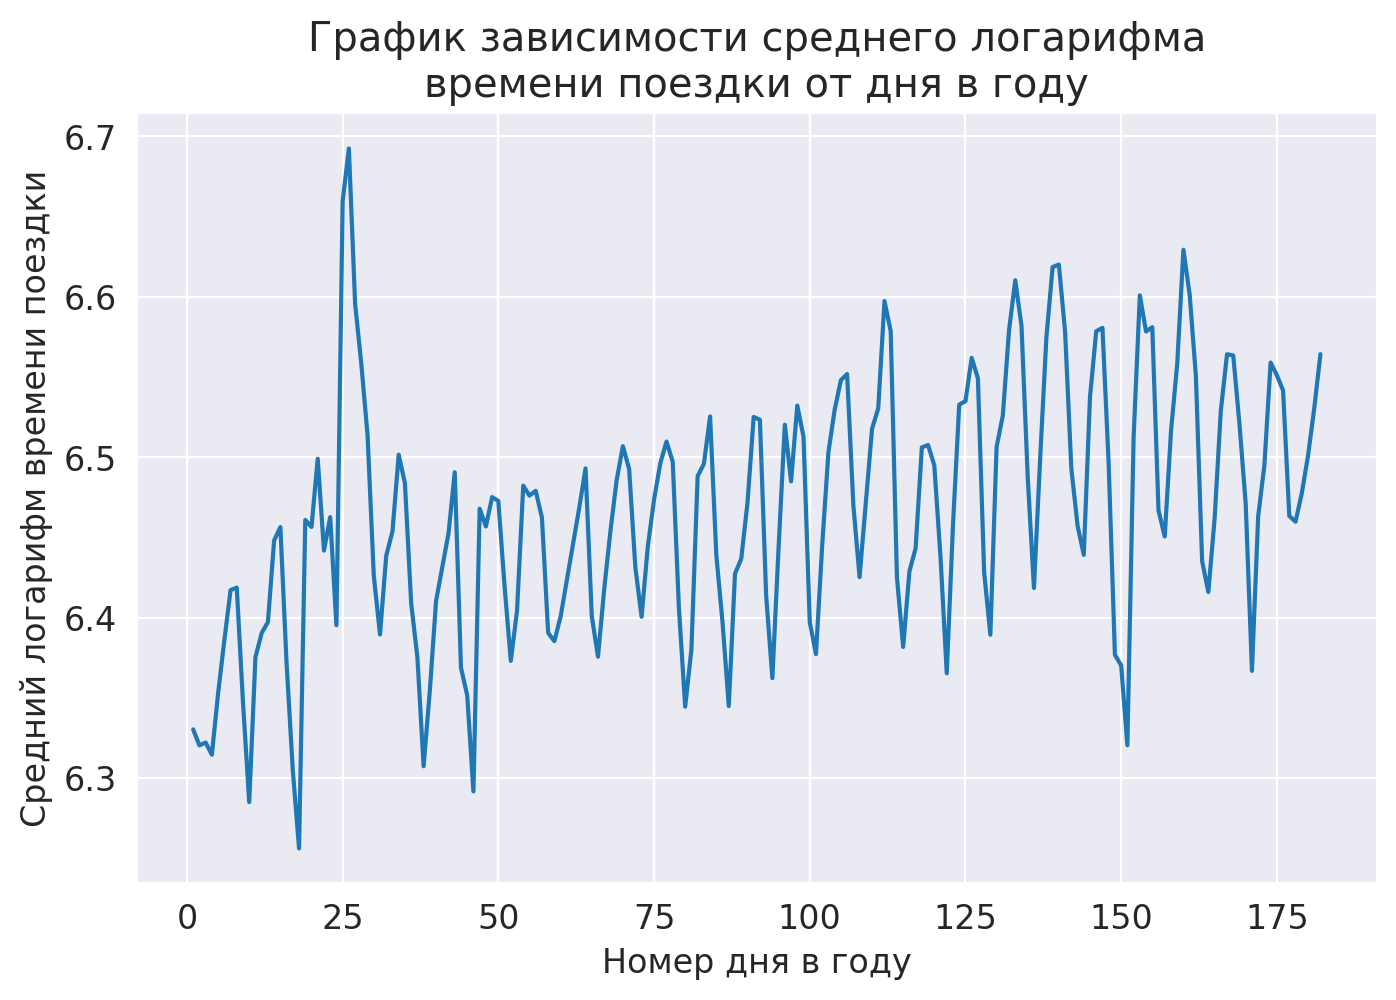

In [32]:
X_train['day_of_year'] = X_train['pickup_datetime'].dt.dayofyear
ser_days_of_year = X_train.groupby('day_of_year')['log_trip_duration'].mean()
x = ser_days_of_year.index
y = ser_days_of_year
plt.plot(x, y)
plt.xlabel('Номер дня в году')
plt.ylabel('Средний логарифм времени поездки')
plt.title('График зависимости среднего логарифма\nвремени поездки от дня в году')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

График зависимости таргета от дня недели приблизительно похож на аналогичный график для количества поездок (только на первом пик достинается в чт, а на втором - в пт). График зависимости таргета от часа в сутках тоже примерно похож похож на аналогичный график для количества поездок (только на первом пик достигается в 15 часов, а на втором - в 18 часов). Эти сходства можно объяснить тем, что, скорее всего, между количеством поездок и логарифмом времени поездки присутствует некоторая корреляция: чем большее количество поездок совершается в определенный период, тем больше время поездки из-за загруженности дорог (а, следовательно, его логарифм тоже больше).

В 1 аномальный период средний таргет показывает значительный рост, а во втором относительно соседних периодов сильное падение. Это может происходить, потому что в 1 период были перекрыты дороги из-за огромного количества снега на них, следовательно, все поездки, которые получалось совершить, были в объезд перекрытий и длились долго как из-за этого, так и из-за мешавших быстрому передвижению погодных условий. Во 2 периоде же, напротив, поездок стало меньше из-за падения спроса на них (в JFK аэропорт не совершались поездки), следовательно, дороги освободились, и поэтому длина поездки (и средний ее логарифм соответственно) уменьшились.

Да, я наблюдаю положительный тренд на графике зависимости среднего log_trip_duration от номера дня в году.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [33]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train['month'] = X_train['pickup_datetime'].dt.month
X_train.loc[(X_train['day_of_year'] == 23) | (X_train['day_of_year'] == 24) | (X_train['day_of_year'] == 25), 'first_anomaly_period'] = 1
X_train.loc[~((X_train['day_of_year'] == 23) | (X_train['day_of_year'] == 24) | (X_train['day_of_year'] == 25)), 'first_anomaly_period'] = 0
X_train.loc[(X_train['day_of_year'] == 150) | (X_train['day_of_year'] == 151), 'second_anomaly_period'] = 1
X_train.loc[~((X_train['day_of_year'] == 150) | (X_train['day_of_year'] == 151)), 'second_anomaly_period'] = 0

X_test['day_of_week'] = X_test['pickup_datetime'].dt.dayofweek
X_test['hour'] = X_test['pickup_datetime'].dt.hour
X_test['day_of_year'] = X_test['pickup_datetime'].dt.dayofyear
X_test['month'] = X_test['pickup_datetime'].dt.month
X_test.loc[(X_test['day_of_year'] == 23) | (X_test['day_of_year'] == 24) | (X_test['day_of_year'] == 25), 'first_anomaly_period'] = 1
X_test.loc[~((X_test['day_of_year'] == 23) | (X_test['day_of_year'] == 24) | (X_test['day_of_year'] == 25)), 'first_anomaly_period'] = 0
X_test.loc[(X_test['day_of_year'] == 150) | (X_test['day_of_year'] == 151), 'second_anomaly_period'] = 1
X_test.loc[~((X_test['day_of_year'] == 150) | (X_test['day_of_year'] == 151)), 'second_anomaly_period'] = 0

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Все созданные признаки стоит рассматривать в этой задаче как категориальные, так как в отличие от числовых их значения (дня недели, месяца, часа, аномальности и номера дня в году) "нельзя складывать и сравнивать" друг с другом.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [34]:
X_train_new = X_train[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period']]
X_test_new = X_test[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period']]

In [35]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical = list(X_train_new.columns)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.7865


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [36]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [37]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_samp = df.sample(1000)
your_lat_values = df_samp['pickup_latitude']
your_lon_values = df_samp['pickup_longitude']

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

По моему мнению, от основной массы выделяются и могут быть полезны для нашей задачи следующие 2 скопления точек: аэропорт LaGuardia и аэропорт John F. Kennedy. Я их выбрал, потому что несмотря на то, что в основной массе (на юге Манхэттена) совершается наибольшее количество поездок на такси, достаточно много поездок люди совершают до двух крупнейших аэропортов Нью-Йорка. Следовательно, нам важно, чтобы модель, которая хорошо обучится предсказывать длину поездок, совершаемых в основной массе (на юге Манхэттена), хорошо предсказывала длину поездок в аэропорты (наши 2 скопления точек).

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [38]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

X_train.loc[:, 'haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [39]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.loc[:, 'log_haversine'] = np.log1p(X_train['haversine'].values) # используем np.log1p, чтобы избежать ln(0)
X_test.loc[:, 'log_haversine'] = np.log1p(X_test['haversine'].values)

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

<Axes: xlabel='Коэффициенты корреляции', ylabel='Переменные'>

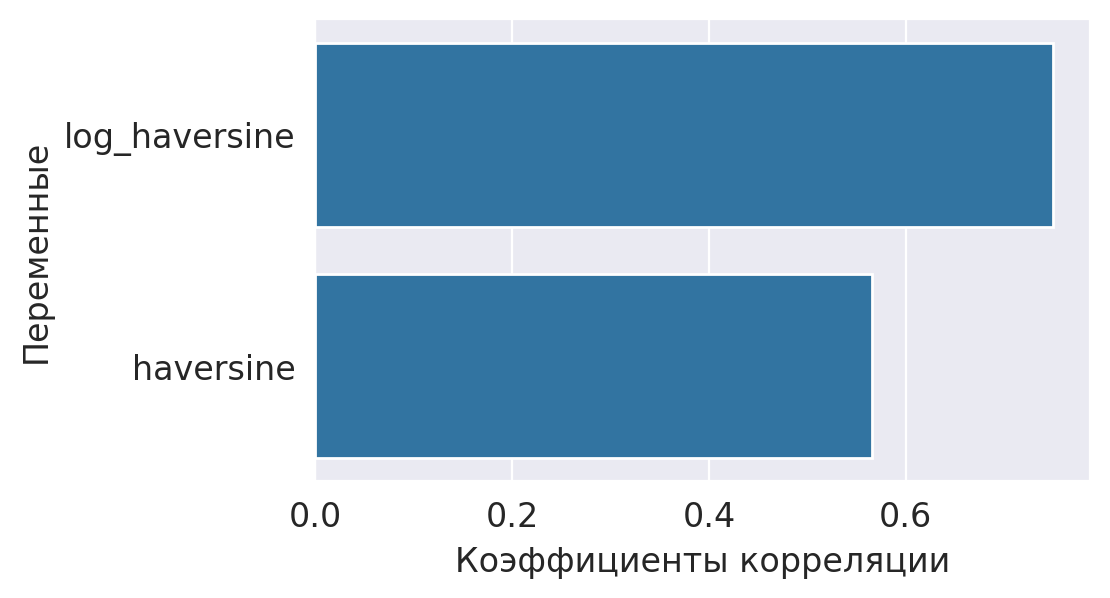

In [40]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
correlations = X_train[['log_haversine', 'haversine']].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)

plot.figure.set_size_inches(5, 3)
plot.set_xlabel('Коэффициенты корреляции')
plot.set_ylabel('Переменные')
plot

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

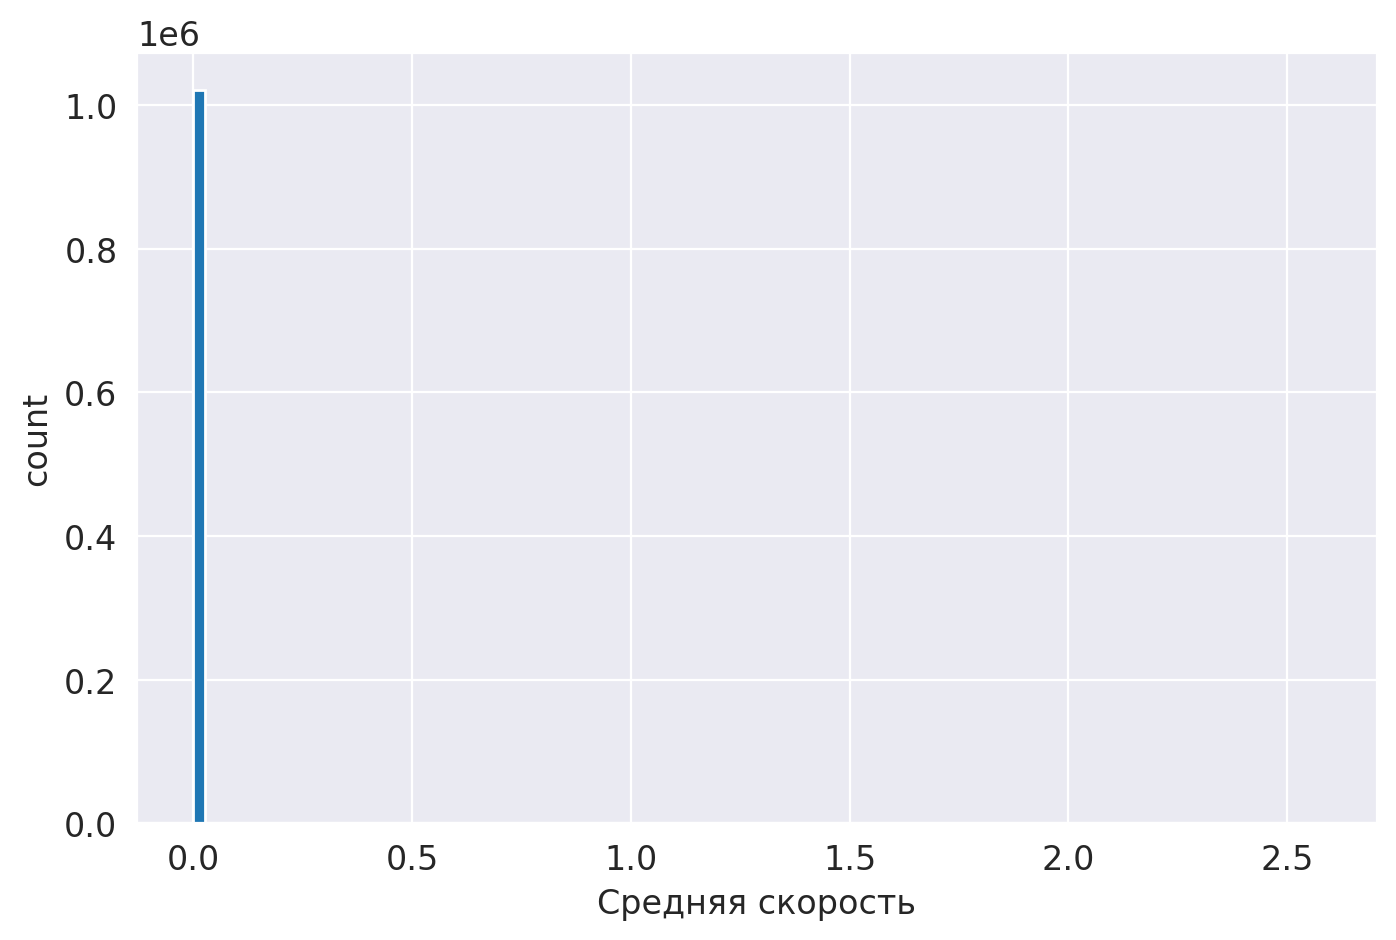

In [41]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.loc[:, 'average_speed'] = X_train['haversine'].values / (np.exp(X_train['log_trip_duration'].values) - 1)
plt.hist(X_train['average_speed'].values, bins=100)
plt.xlabel('Средняя скорость')
plt.ylabel('count')
plt.show()

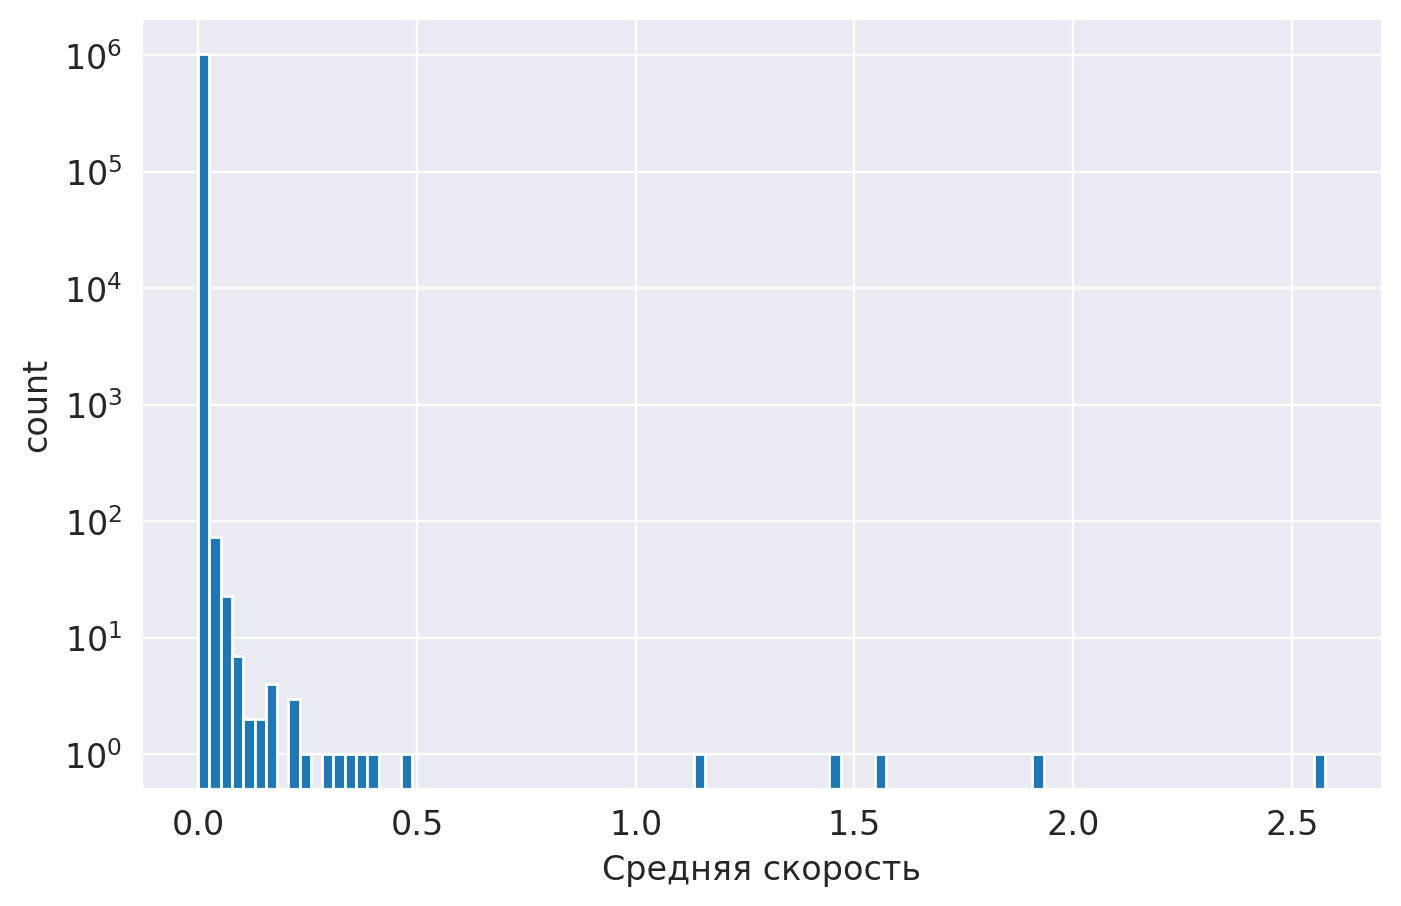

In [42]:
X_train.loc[:, 'average_speed'] = X_train['haversine'].values / (np.exp(X_train['log_trip_duration'].values) - 1)
plt.hist(X_train['average_speed'].values, bins=100)
plt.xlabel('Средняя скорость')
plt.ylabel('count')
plt.yscale('log')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

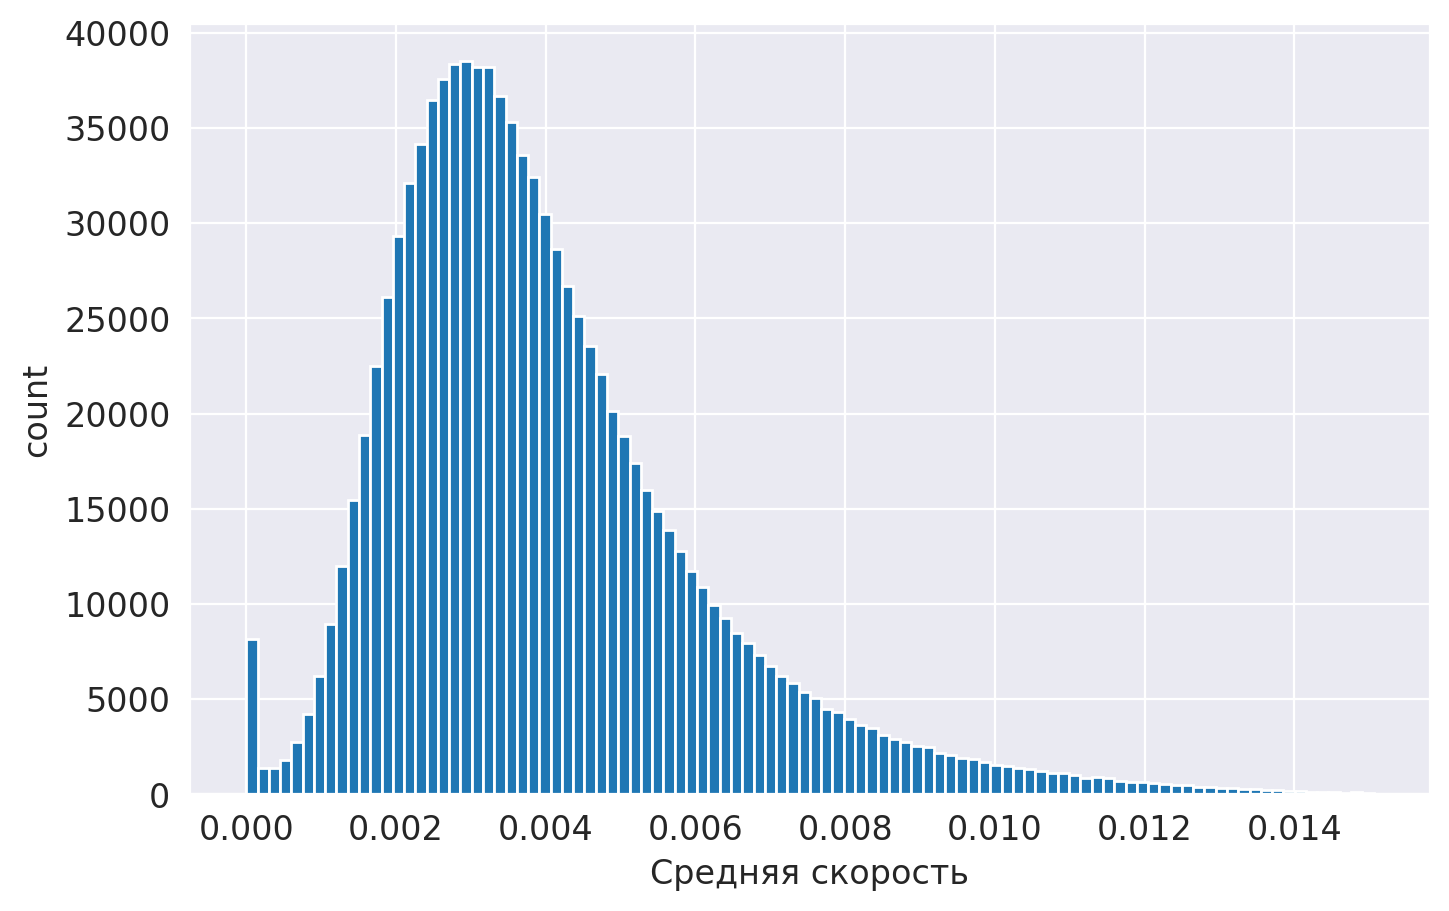

In [43]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(X_train[X_train['average_speed'] < np.quantile(X_train['average_speed'], 0.999)]['average_speed'].values, bins=100)
plt.xlabel('Средняя скорость')
plt.ylabel('count')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

Text(91.48784722222221, 0.5, 'День недели')

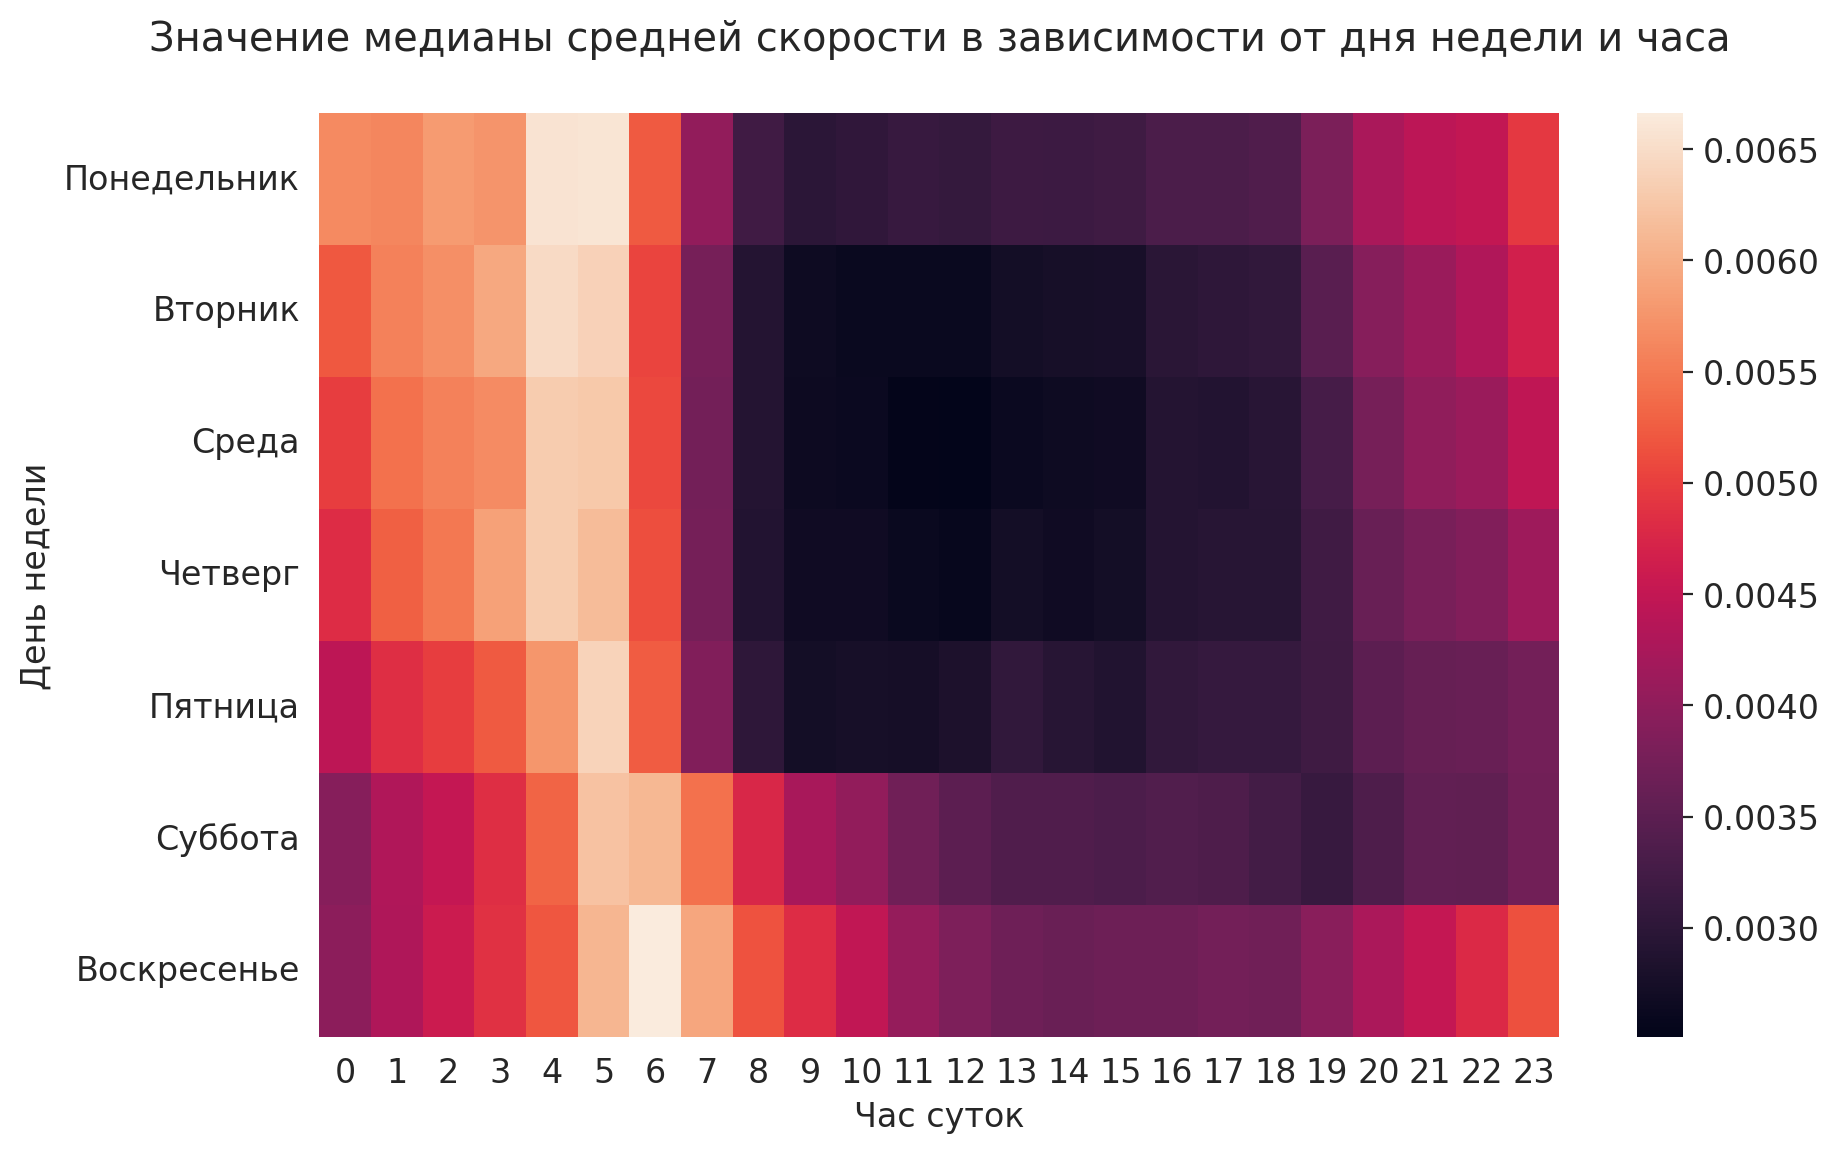

In [44]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_med_average_speed = X_train.groupby(['day_of_week', 'hour'], as_index=False)['average_speed'].median()
df_med_average_speed_new = pd.pivot_table(data=df_med_average_speed, index='day_of_week', columns='hour', values='average_speed')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(df_med_average_speed_new,
                 ax=ax,
                 yticklabels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

ax.set_title('Значение медианы средней скорости в зависимости от дня недели и часа\n')
ax.set_xlabel('Час суток')
ax.set_ylabel('День недели')

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Значение средней скорости равно частному длины и времени поездки. Логарифм времени поездки мы должны предсказывать, а так как модель может, зная  длину поездки и среднюю скорость, вычислить таргет и подобрать идеальные коэффициенты для обучающей выборки, т.е. будет идеально предсказывать таргет для обучающей выборки (и, скорее всего, забьет на остальные параметры), что, весьма вероятно, приведёт к плохой работе модели на тестовой выборке. По этой же причине мы удаляем колонку с таргетом из обучающей выборки.

In [45]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.drop(columns=['average_speed'], inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Судя по графику, скорость максимальна в 6 часов в воскресенье, а минимальна в 11-12 часов в среду.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Внимательно рассмотрев heatmap, я решил, что пусть периоды свободных дорог: в пн-чт 4-5 часов, в пт 5 часов, в сб-вс 5-6 часов,

а периоды пробок: во вт-чт 9-15 часов, в пт 9-12 часов.

In [46]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.loc[:, 'free_roads'] = 0
X_train.loc[((X_train['hour'] == 4) | (X_train['hour'] == 5)) & ((X_train['day_of_week'] == 0) | (X_train['day_of_week'] == 1) | (X_train['day_of_week'] == 2) | (X_train['day_of_week'] == 3)), 'free_roads'] = 1 # пн-чт 4-5 часов
X_train.loc[(X_train['hour'] == 5) & (X_train['day_of_week'] == 4), 'free_roads'] = 1 # пт 5 часов
X_train.loc[((X_train['hour'] == 5) | (X_train['hour'] == 6)) & ((X_train['day_of_week'] == 5) | (X_train['day_of_week'] == 6)), 'free_roads'] = 1 # сб-вс 5-6 часов

X_train.loc[:, 'traffic_jams'] = 0
X_train.loc[((X_train['hour'] == 9) | (X_train['hour'] == 10) | (X_train['hour'] == 11) | (X_train['hour'] == 12) | (X_train['hour'] == 13) | (X_train['hour'] == 14) | (X_train['hour'] == 15)) & ((X_train['day_of_week'] == 1) | (X_train['day_of_week'] == 2) | (X_train['day_of_week'] == 3)), 'traffic_jams'] = 1 # вт-чт 9-15 часов
X_train.loc[((X_train['hour'] == 9) | (X_train['hour'] == 10) | (X_train['hour'] == 11) | (X_train['hour'] == 12)) & (X_train['day_of_week'] == 4), 'traffic_jams'] = 1 # пт 9-12 часов



X_test.loc[:, 'free_roads'] = 0
X_test.loc[((X_test['hour'] == 4) | (X_test['hour'] == 5)) & ((X_test['day_of_week'] == 0) | (X_test['day_of_week'] == 1) | (X_test['day_of_week'] == 2) | (X_test['day_of_week'] == 3)), 'free_roads'] = 1 # пн-чт 4-5 часов
X_test.loc[(X_test['hour'] == 5) & (X_test['day_of_week'] == 4), 'free_roads'] = 1 # пт 5 часов
X_test.loc[((X_test['hour'] == 5) | (X_test['hour'] == 6)) & ((X_test['day_of_week'] == 5) | (X_test['day_of_week'] == 6)), 'free_roads'] = 1 # сб-вс 5-6 часов

X_test.loc[:, 'traffic_jams'] = 0
X_test.loc[((X_test['hour'] == 9) | (X_test['hour'] == 10) | (X_test['hour'] == 11) | (X_test['hour'] == 12) | (X_test['hour'] == 13) | (X_test['hour'] == 14) | (X_test['hour'] == 15)) & ((X_test['day_of_week'] == 1) | (X_test['day_of_week'] == 2) | (X_test['day_of_week'] == 3)), 'traffic_jams'] = 1 # вт-чт 9-15 часов
X_test.loc[((X_test['hour'] == 9) | (X_test['hour'] == 10) | (X_test['hour'] == 11) | (X_test['hour'] == 12)) & (X_test['day_of_week'] == 4), 'traffic_jams'] = 1 # пт 9-12 часов

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Эти признаки могут быть полезны, поскольку позволят модели выделить особенности поездок в аэропорты и из аэропортов и, как следствие, лучше предсказывать длительность поездок в/из этих пунктов (тем более это нужно, ведь количество поездок в аэропорты существенно меньше по сравнению с количеством поездок в центре (в Манхэттене)).

In [47]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
jfk_airport_lat1 = 40.669089
jfk_airport_long1 = -73.824374
jfk_airport_lat2 = 40.618030
jfk_airport_long2 = -73.745238

X_train.loc[:, 'pickup_jfk'] = 0
X_train.loc[(X_train['pickup_latitude'] >= jfk_airport_lat2) & (X_train['pickup_latitude'] <= jfk_airport_lat1) & (X_train['pickup_longitude'] >= jfk_airport_long1) & (X_train['pickup_longitude'] <= jfk_airport_long2), 'pickup_jfk'] = 1

X_train.loc[:, 'dropoff_jfk'] = 0
X_train.loc[(X_train['dropoff_latitude'] >= jfk_airport_lat2) & (X_train['dropoff_latitude'] <= jfk_airport_lat1) & (X_train['dropoff_longitude'] >= jfk_airport_long1) & (X_train['dropoff_longitude'] <= jfk_airport_long2), 'dropoff_jfk'] = 1

lga_airport_lat1 = 40.786607
lga_airport_long1 = -73.888790
lga_airport_lat2 = 40.765808
lga_airport_long2 = -73.854629

X_train.loc[:, 'pickup_lga'] = 0
X_train.loc[(X_train['pickup_latitude'] >= lga_airport_lat2) & (X_train['pickup_latitude'] <= lga_airport_lat1) & (X_train['pickup_longitude'] >= lga_airport_long1) & (X_train['pickup_longitude'] <= lga_airport_long2), 'pickup_lga'] = 1

X_train.loc[:, 'dropoff_lga'] = 0
X_train.loc[(X_train['dropoff_latitude'] >= lga_airport_lat2) & (X_train['dropoff_latitude'] <= lga_airport_lat1) & (X_train['dropoff_longitude'] >= lga_airport_long1) & (X_train['dropoff_longitude'] <= lga_airport_long2), 'dropoff_lga'] = 1


X_test.loc[:, 'pickup_jfk'] = 0
X_test.loc[(X_test['pickup_latitude'] >= jfk_airport_lat2) & (X_test['pickup_latitude'] <= jfk_airport_lat1) & (X_test['pickup_longitude'] >= jfk_airport_long1) & (X_test['pickup_longitude'] <= jfk_airport_long2), 'pickup_jfk'] = 1

X_test.loc[:, 'dropoff_jfk'] = 0
X_test.loc[(X_test['dropoff_latitude'] >= jfk_airport_lat2) & (X_test['dropoff_latitude'] <= jfk_airport_lat1) & (X_test['dropoff_longitude'] >= jfk_airport_long1) & (X_test['dropoff_longitude'] <= jfk_airport_long2), 'dropoff_jfk'] = 1

X_test.loc[:, 'pickup_lga'] = 0
X_test.loc[(X_test['pickup_latitude'] >= lga_airport_lat2) & (X_test['pickup_latitude'] <= lga_airport_lat1) & (X_test['pickup_longitude'] >= lga_airport_long1) & (X_test['pickup_longitude'] <= lga_airport_long2), 'pickup_lga'] = 1

X_test.loc[:, 'dropoff_lga'] = 0
X_test.loc[(X_test['dropoff_latitude'] >= lga_airport_lat2) & (X_test['dropoff_latitude'] <= lga_airport_lat1) & (X_test['dropoff_longitude'] >= lga_airport_long1) & (X_test['dropoff_longitude'] <= lga_airport_long2), 'dropoff_lga'] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

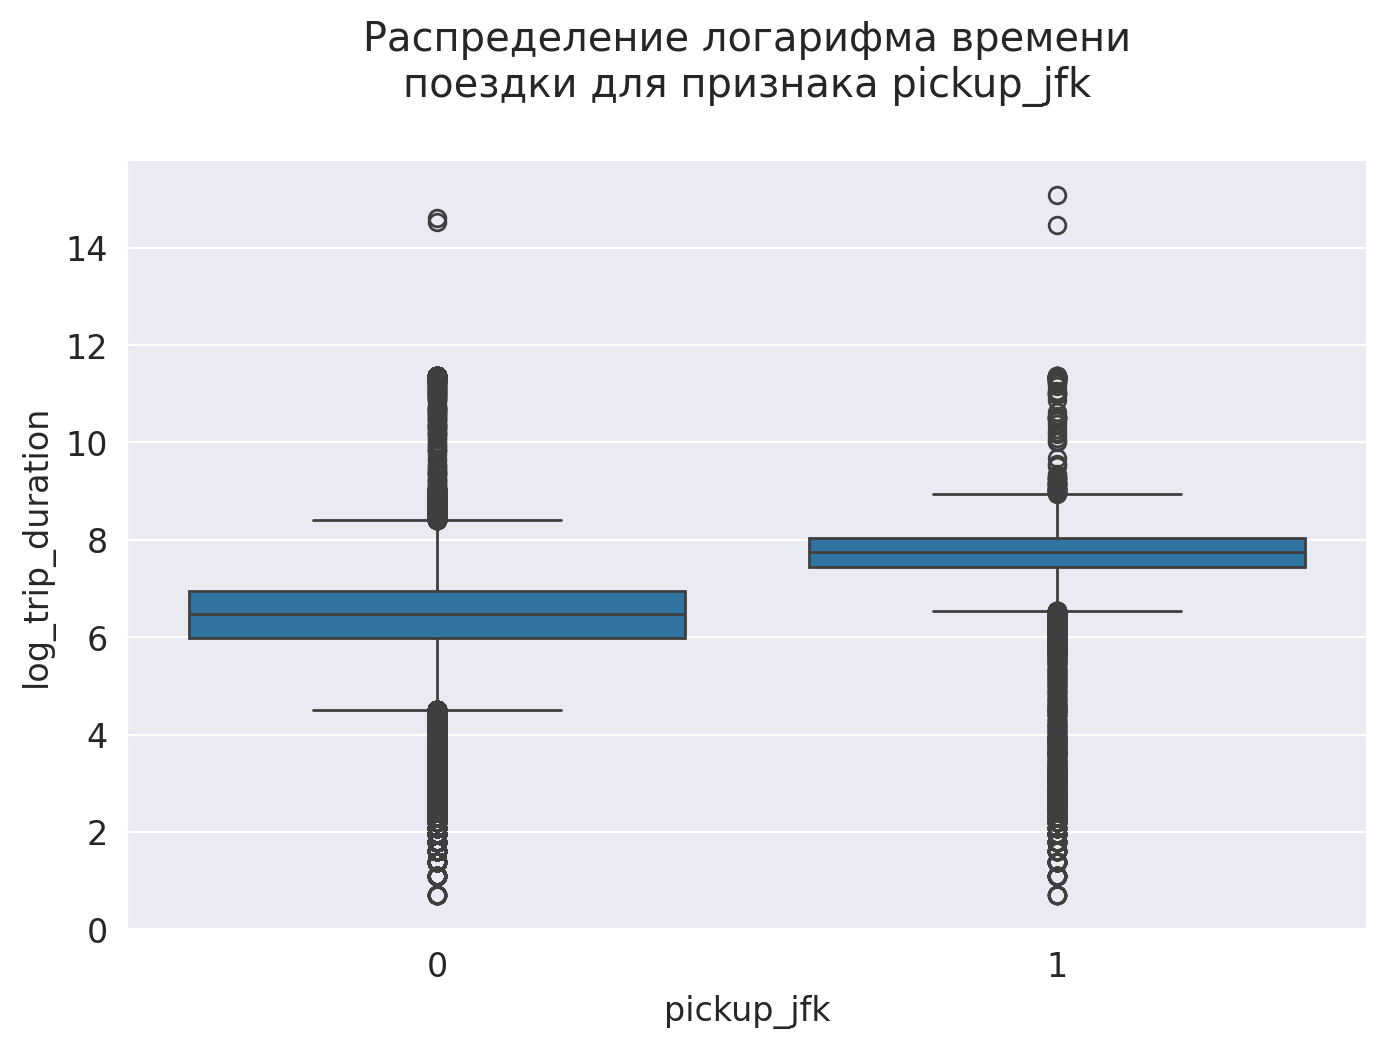

In [48]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(x='pickup_jfk', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака pickup_jfk\n')
plt.show()

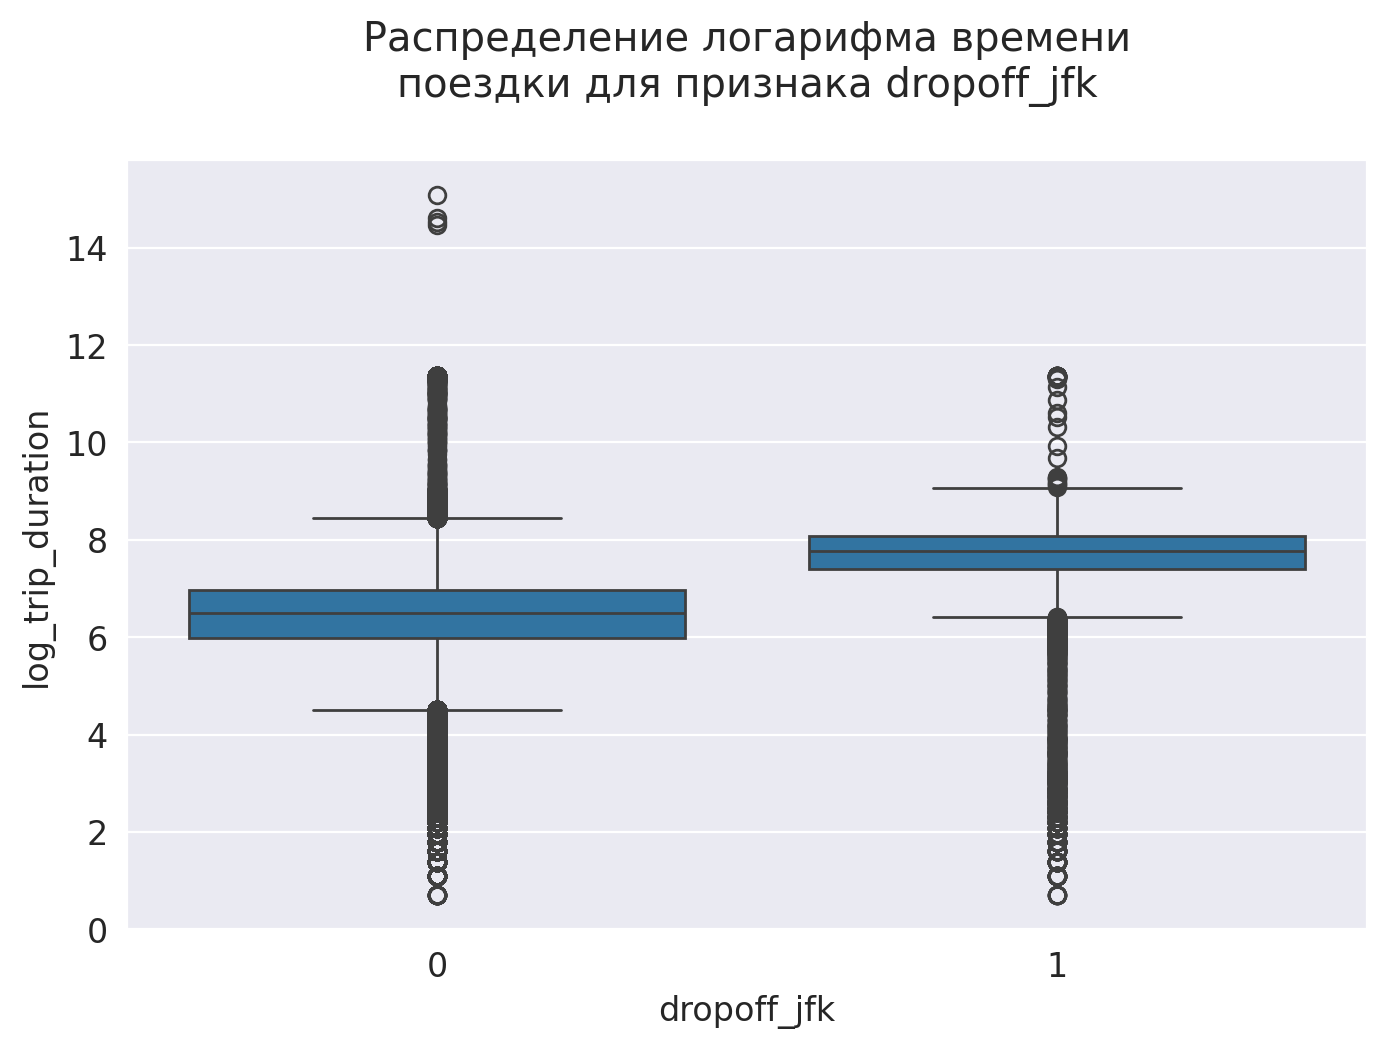

In [49]:
sns.boxplot(x='dropoff_jfk', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака dropoff_jfk\n')
plt.show()

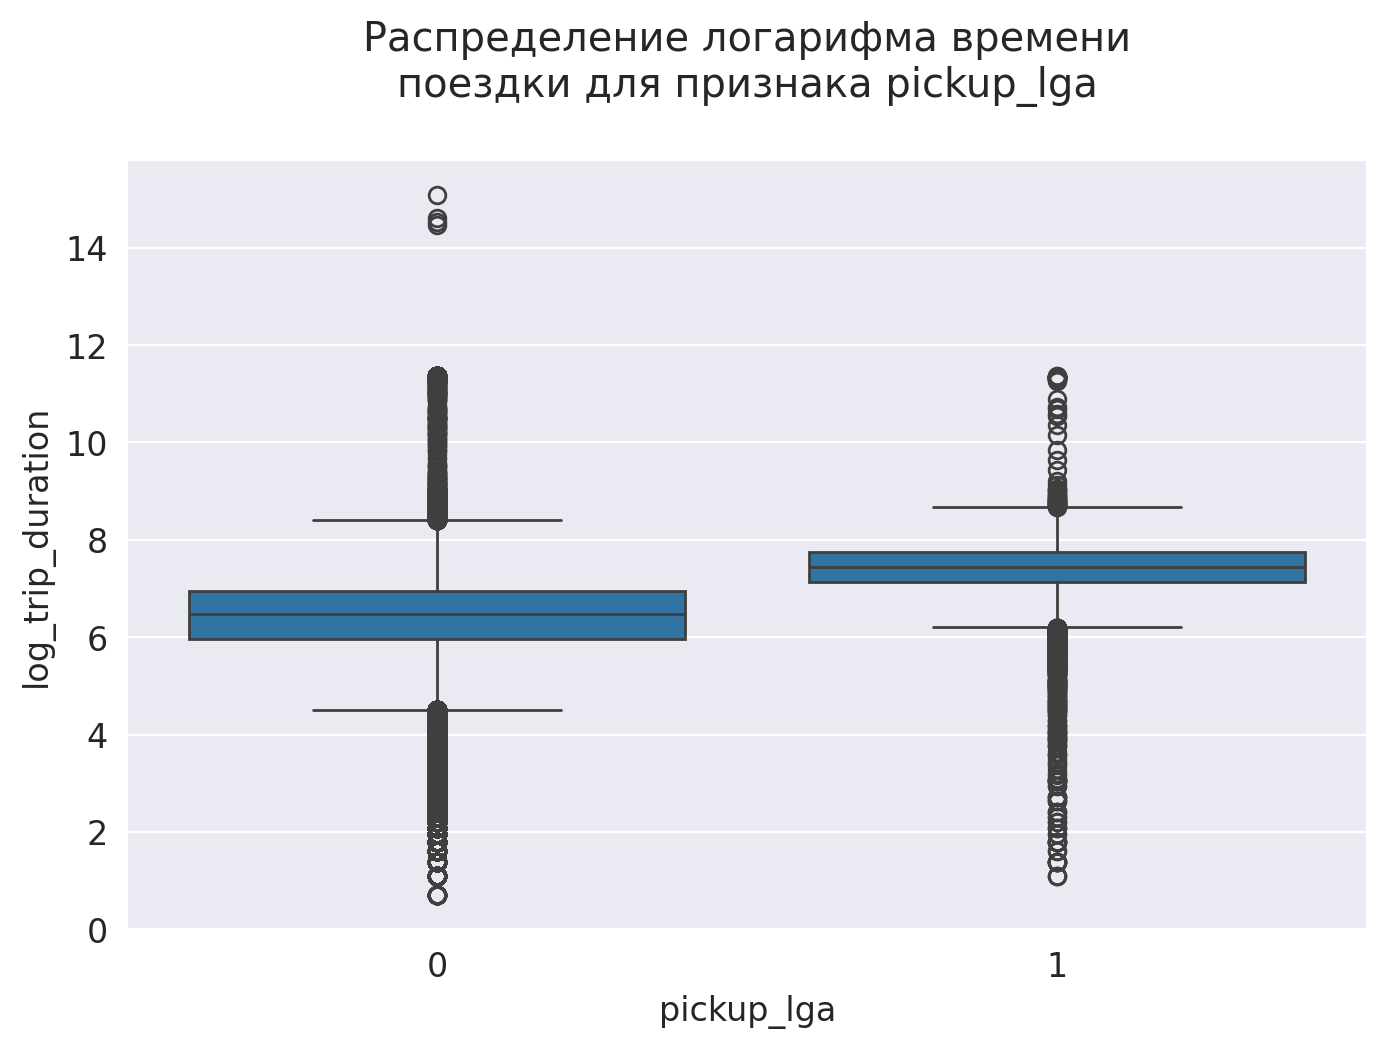

In [50]:
sns.boxplot(x='pickup_lga', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака pickup_lga\n')
plt.show()

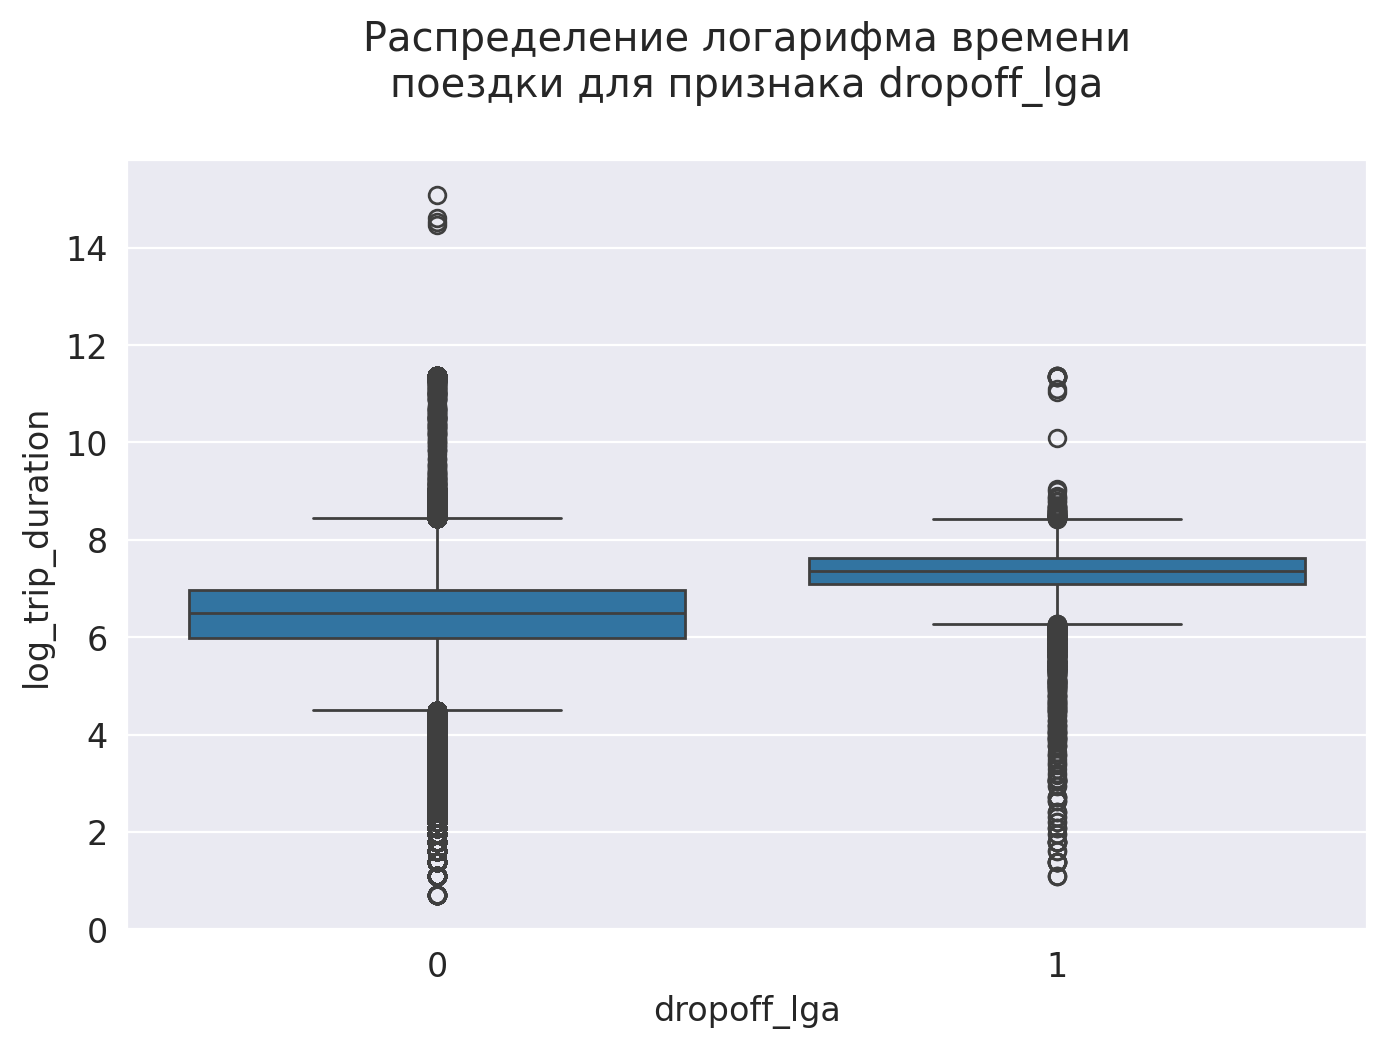

In [51]:
sns.boxplot(x='dropoff_lga', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака dropoff_lga\n')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

На графике каждого признака видно, что распределение логарифма времени поездки для объектов, которые им обладают (у которых он равен 1), отличается от распределения логарифма времени поездки для объектов, которые им не обладают (у которых он равен 0): для основной массы объектов, обладающих признаком, таргет (логарифм времени поездки) больше, чем таргет для основной массы объектов, не обладающих признаком. По этой причине можно считать признаки хорошими, так как они позволят лучше предсказывать таргет для объектов, обладающих признаками (модель будет учитывать, что в/из аэропорта ехать дольше).

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

Сделал это задание с помощью чата гпт, в качестве промпта было: "вот есть следующее задание [текст задания] и надо дописать следующий код класса [шаблон кода, который был ниже]". Я отредактировал выданный языковой моделью код (дописал некоторые моменты, как, например, координаты точек, которые ограничивают прямоугольник над Манхэттеном, а некоторые убрал, так как они были лишними и мешали выполнению программы) и добавил свои комментарии.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows = 6, n_cols = 4):
        # your code here
        self.n_rows = n_rows  # количество строк в сетке
        self.n_cols = n_cols  # количество столбцов в сетке
        # нижняя левая точка прямоугольника (40.706937, -74.019615)
        # верхняя правая точка прямоугольника (40.797921, -73.936162)
        self.min_lat = 40.706937
        self.max_lat = 40.797921
        self.min_lon = -74.019615
        self.max_lon = -73.936162
        self.lat_bins = None
        self.lon_bins = None

    def show_map(self):
        # you may want to visualize cells
        # не получилось сделать этот метод
        pass

    def fit(self, X=None, y=None):
        # your code here
        # создаем границы клеток, на которые разбили прямоугольник
        self.lat_bins = np.linspace(self.min_lat, self.max_lat, self.n_rows + 1)
        self.lon_bins = np.linspace(self.min_lon, self.max_lon, self.n_cols + 1)
        return self

    def transform(self, X, y=None):
        # your code here
        # отмечаем точки для ячеек (помечаем номер строки по lat и номер столбца по lon)
        pickup_lat_bin = np.digitize(X['pickup_latitude'], self.lat_bins) - 1 # вычитаем 1, так как в np.digitize нумерация интервалов начинается с 1, а не с 0
        pickup_lon_bin = np.digitize(X['pickup_longitude'], self.lon_bins) - 1
        dropoff_lat_bin = np.digitize(X['dropoff_latitude'], self.lat_bins) - 1
        dropoff_lon_bin = np.digitize(X['dropoff_longitude'], self.lon_bins) - 1

        # получаем номер ячейки в целом
        # pickup_lat_bin и pickup_lon_bin начинаются с 0 и нумерация ячеек прямоугольника 6x4 идет след образом: 1 строка: 0,1,2,3,4,5; 2 строка: 6,7,8,9,10,11 и т.д.
        pickup_cell = pickup_lat_bin * self.n_cols + pickup_lon_bin
        dropoff_cell = dropoff_lat_bin * self.n_cols + dropoff_lon_bin

        # ставим в признаки pickup_cell и dropoff_cell -1 тем объектам, которые не попали в большой прямоугольник
        pickup_cell[(pickup_lat_bin < 0) | (pickup_lat_bin >= self.n_rows) | (pickup_lon_bin < 0) | (pickup_lon_bin >= self.n_cols)] = -1
        dropoff_cell[(dropoff_lat_bin < 0) | (dropoff_lat_bin >= self.n_rows) | (dropoff_lon_bin < 0) | (dropoff_lon_bin >= self.n_cols)] = -1

        # создаем копию передаваемой в класс выборки и добавляем в нее новые признаки
        X_transformed = X.copy()
        X_transformed['pickup_cell'] = pickup_cell
        X_transformed['dropoff_cell'] = dropoff_cell
        return X_transformed

In [53]:
grid1 = MapGridTransformer()
X_train_transformed = grid1.fit().transform(X_train)
X_test_transformed = grid1.fit().transform(X_test)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [54]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train_transformed_new = X_train_transformed[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'log_haversine', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell']]
X_test_transformed_new = X_test_transformed[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'log_haversine', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell']]

In [55]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
categorical = ['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell']
numeric_features = ['log_haversine']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_transformed_new, y_train)
y_pred = model.predict(X_test_transformed_new)

print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4723


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

vendor_id может быть полезным, так как от оператора такси (фирмы, под которой работает таксист) может зависеть его квалификация и время поездки, как следствие

passenger_count может быть полезным, так как от количества пассажиров, возможно, зависит пункт назначения

store_and_fwd_flag может быть полезным, так как в данных мог быть какой-то сбой, если они не были отправлены на сервера сразу, а хранились на устройстве у таксиста некоторое время до отправки

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [56]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print("Количество уникальных значений у признака vendor_id:", X_train['vendor_id'].nunique())
print("Количество уникальных значений у признака passenger_count:", X_train['passenger_count'].nunique())
print("Количество уникальных значений у признака store_and_fwd_flag:", X_train['store_and_fwd_flag'].nunique())

Количество уникальных значений у признака vendor_id: 2
Количество уникальных значений у признака passenger_count: 9
Количество уникальных значений у признака store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

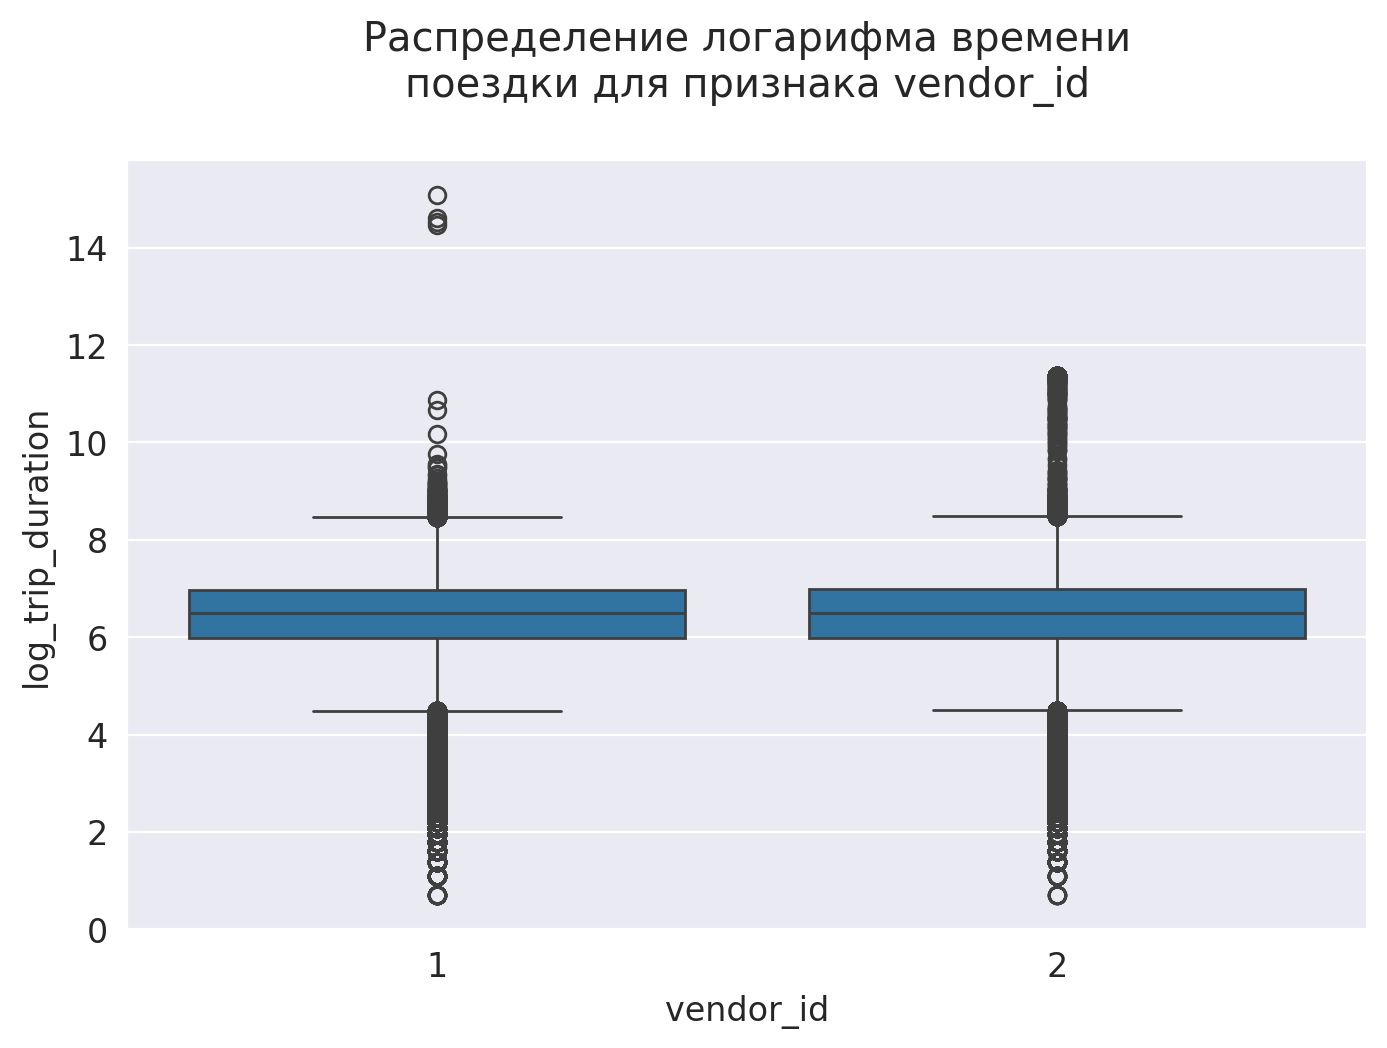

In [57]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(x='vendor_id', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака vendor_id\n')
plt.show()

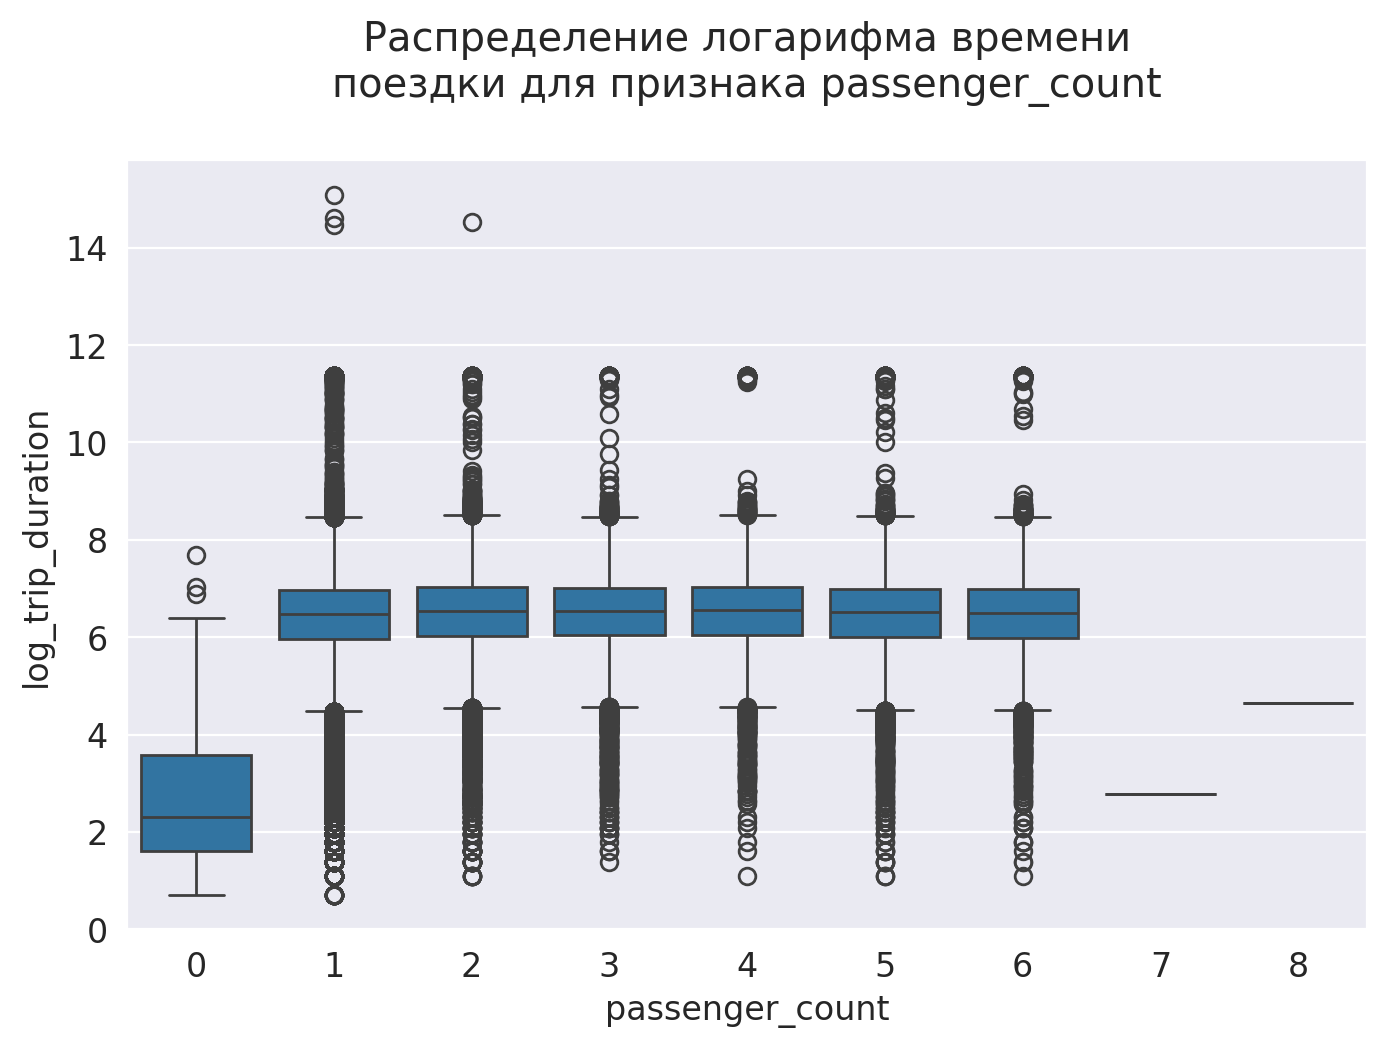

In [58]:
sns.boxplot(x='passenger_count', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака passenger_count\n')
plt.show()

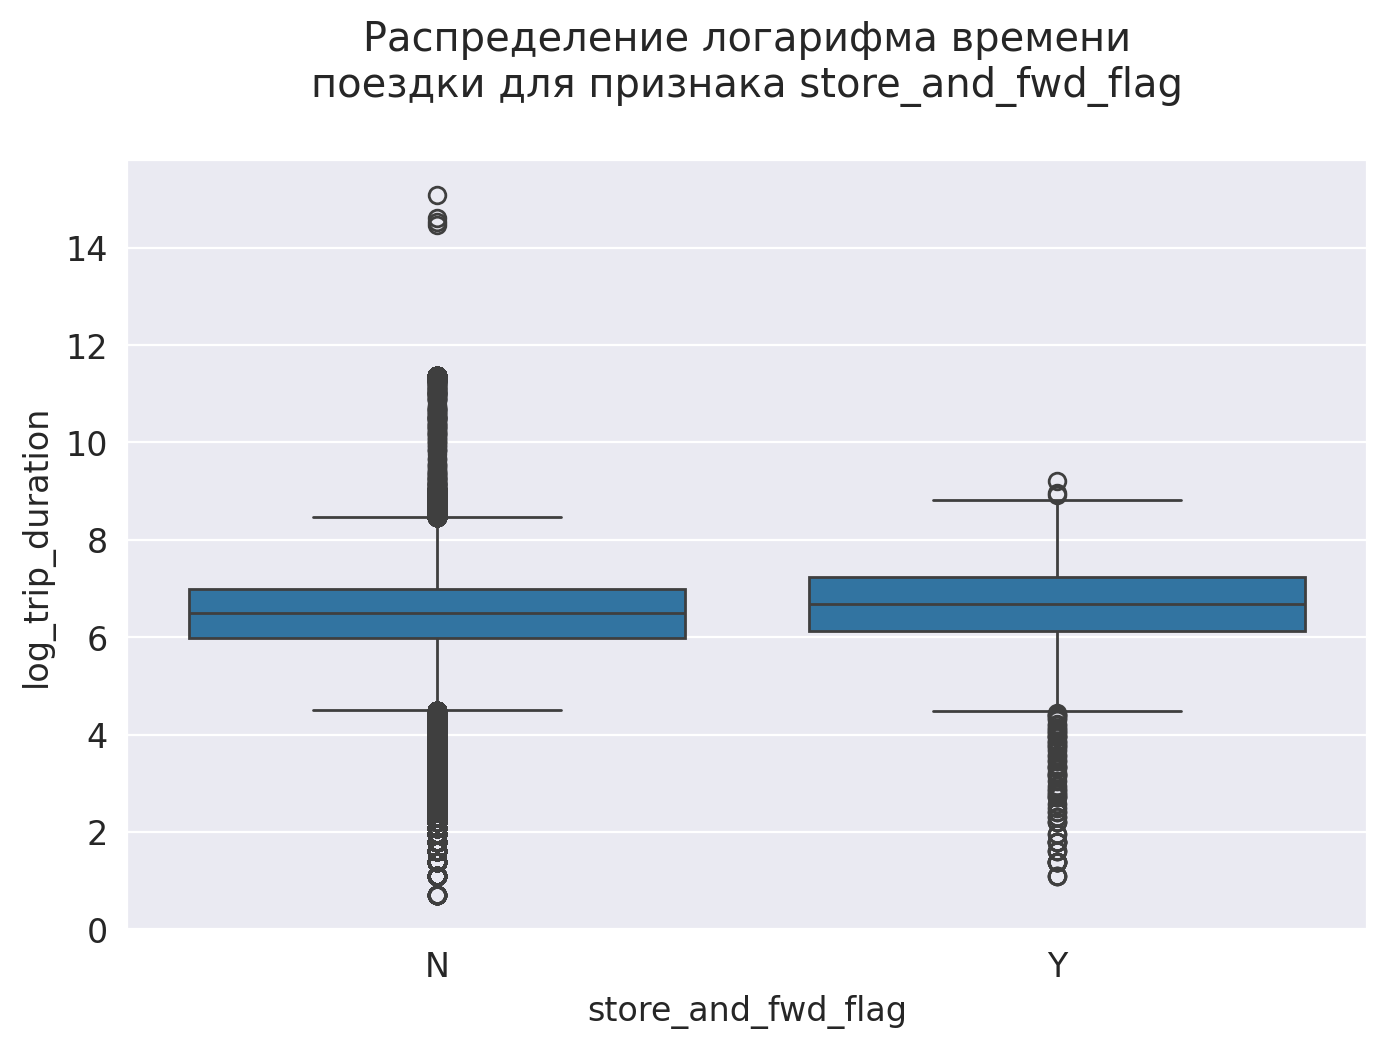

In [59]:
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=X_train).set_title('Распределение логарифма времени\nпоездки для признака store_and_fwd_flag\n')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [60]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_train.loc[X_train['vendor_id'] == 1, 'vendor_id'] = 0
X_train.loc[X_train['vendor_id'] == 2, 'vendor_id'] = 1
X_train

vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
824746           1 2016-03-27 00:25:29                3        -73.996986   
645821           1 2016-03-18 20:44:12                1        -73.989929   
691846           1 2016-04-15 18:26:12                2        -73.972366   
1147931          1 2016-03-24 14:28:34                1        -73.982361   
183569           0 2016-04-28 13:53:52                1        -73.973778   
...            ...                 ...              ...               ...   
1348317          0 2016-05-12 05:16:06                1        -73.996178   
1154171          0 2016-01-16 19:14:54                1        -73.995415   
617841           0 2016-03-21 20:11:12                1        -73.960091   
1048548          0 2016-04-09 09:21:44                1        -73.968124   
1393929          0 2016-04-27 09:11:19                1        -74.004715   

         pickup_latitude  dropoff_longitude  dropoff_latitude  \
824746         40.742210         -73.987740         40.710659   
645821         40.741760         -73.977280         40.783600   
691846         40.750725         -73.861832         40.768387   
1147931        40.776901         -73.975128         40.760921   
183569         40.764374         -73.966957         40.761024   
...                  ...                ...               ...   
1348317        40.748222         -73.990967         40.755478   
1154171        40.728886         -73.993706         40.744068   
617841         40.779701         -73.960136         40.773102   
1048548        40.799923         -73.952415         40.818588   
1393929        40.707268         -74.014168         40.713989   

        store_and_fwd_flag  log_trip_duration  day_of_week  ...  \
824746                   N           7.134891            6  ...   
645821                   N           6.878326            4  ...   
691846                   N           7.642524            4  ...   
1147931                  N           6.888572            3  ...   
183569                   N           6.177944            3  ...   
...                    ...                ...          ...  ...   
1348317                  N           5.198497            3  ...   
1154171                  N           8.787678            5  ...   
617841                   N           5.023881            0  ...   
1048548                  N           6.079933            5  ...   
1393929                  N           7.148346            2  ...   

         first_anomaly_period  second_anomaly_period  haversine  \
824746                    0.0                    0.0   3.593840   
645821                    0.0                    0.0   4.772773   
691846                    0.0                    0.0   9.514706   
1147931                   0.0                    0.0   1.878364   
183569                    0.0                    0.0   0.684609   
...                       ...                    ...        ...   
1348317                   0.0                    0.0   0.918456   
1154171                   0.0                    0.0   1.694346   
617841                    0.0                    0.0   0.733833   
1048548                   0.0                    0.0   2.460812   
1393929                   0.0                    0.0   1.092435   

         log_haversine  free_roads  traffic_jams  pickup_jfk  dropoff_jfk  \
824746        1.524716           0             0           0            0   
645821        1.753153           0             0           0            0   
691846        2.352775           0             0           0            0   
1147931       1.057222           0             1           0            0   
183569        0.521533           0             1           0            0   
...                ...         ...           ...         ...          ...   
1348317       0.651521           1             0           0            0   
1154171       0.991155           0             0           0            0   


In [61]:
X_train.loc[X_train['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_train.loc[X_train['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1
X_train

vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
824746           1 2016-03-27 00:25:29                3        -73.996986   
645821           1 2016-03-18 20:44:12                1        -73.989929   
691846           1 2016-04-15 18:26:12                2        -73.972366   
1147931          1 2016-03-24 14:28:34                1        -73.982361   
183569           0 2016-04-28 13:53:52                1        -73.973778   
...            ...                 ...              ...               ...   
1348317          0 2016-05-12 05:16:06                1        -73.996178   
1154171          0 2016-01-16 19:14:54                1        -73.995415   
617841           0 2016-03-21 20:11:12                1        -73.960091   
1048548          0 2016-04-09 09:21:44                1        -73.968124   
1393929          0 2016-04-27 09:11:19                1        -74.004715   

         pickup_latitude  dropoff_longitude  dropoff_latitude  \
824746         40.742210         -73.987740         40.710659   
645821         40.741760         -73.977280         40.783600   
691846         40.750725         -73.861832         40.768387   
1147931        40.776901         -73.975128         40.760921   
183569         40.764374         -73.966957         40.761024   
...                  ...                ...               ...   
1348317        40.748222         -73.990967         40.755478   
1154171        40.728886         -73.993706         40.744068   
617841         40.779701         -73.960136         40.773102   
1048548        40.799923         -73.952415         40.818588   
1393929        40.707268         -74.014168         40.713989   

        store_and_fwd_flag  log_trip_duration  day_of_week  ...  \
824746                   0           7.134891            6  ...   
645821                   0           6.878326            4  ...   
691846                   0           7.642524            4  ...   
1147931                  0           6.888572            3  ...   
183569                   0           6.177944            3  ...   
...                    ...                ...          ...  ...   
1348317                  0           5.198497            3  ...   
1154171                  0           8.787678            5  ...   
617841                   0           5.023881            0  ...   
1048548                  0           6.079933            5  ...   
1393929                  0           7.148346            2  ...   

         first_anomaly_period  second_anomaly_period  haversine  \
824746                    0.0                    0.0   3.593840   
645821                    0.0                    0.0   4.772773   
691846                    0.0                    0.0   9.514706   
1147931                   0.0                    0.0   1.878364   
183569                    0.0                    0.0   0.684609   
...                       ...                    ...        ...   
1348317                   0.0                    0.0   0.918456   
1154171                   0.0                    0.0   1.694346   
617841                    0.0                    0.0   0.733833   
1048548                   0.0                    0.0   2.460812   
1393929                   0.0                    0.0   1.092435   

         log_haversine  free_roads  traffic_jams  pickup_jfk  dropoff_jfk  \
824746        1.524716           0             0           0            0   
645821        1.753153           0             0           0            0   
691846        2.352775           0             0           0            0   
1147931       1.057222           0             1           0            0   
183569        0.521533           0             1           0            0   
...                ...         ...           ...         ...          ...   
1348317       0.651521           1             0           0            0   
1154171       0.991155           0             0           0            0   


In [62]:
X_test.loc[X_test['vendor_id'] == 1, 'vendor_id'] = 0
X_test.loc[X_test['vendor_id'] == 2, 'vendor_id'] = 1
X_test.loc[X_test['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_test.loc[X_test['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Навряд ли эти признаки будут сильными, так как различия в распределении логарифма времени поездки у групп объектов с разными значениями признаков практически отсутствуют (только распределение у группы объктов с 0 пассажиров отличается от всех остальных, но это вообще странная группа - что за поездки без пассажиров).

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [63]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
grid2 = MapGridTransformer()
X_train_transformed2 = grid2.fit().transform(X_train)
X_test_transformed2 = grid2.fit().transform(X_test)
X_train_transformed2_new = X_train_transformed2[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'log_haversine', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']]
X_test_transformed2_new = X_test_transformed2[['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'log_haversine', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']]

categorical = ['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['log_haversine']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_transformed2_new, y_train)
y_pred = model.predict(X_test_transformed2_new)

print("Test RMSLE = %.4f" % rmsle(y_test, y_pred))

Test RMSLE = 0.4720


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [64]:
X_train.drop(columns=['vendor_id', 'store_and_fwd_flag', 'passenger_count'], inplace=True)
X_test.drop(columns=['vendor_id', 'store_and_fwd_flag', 'passenger_count'], inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

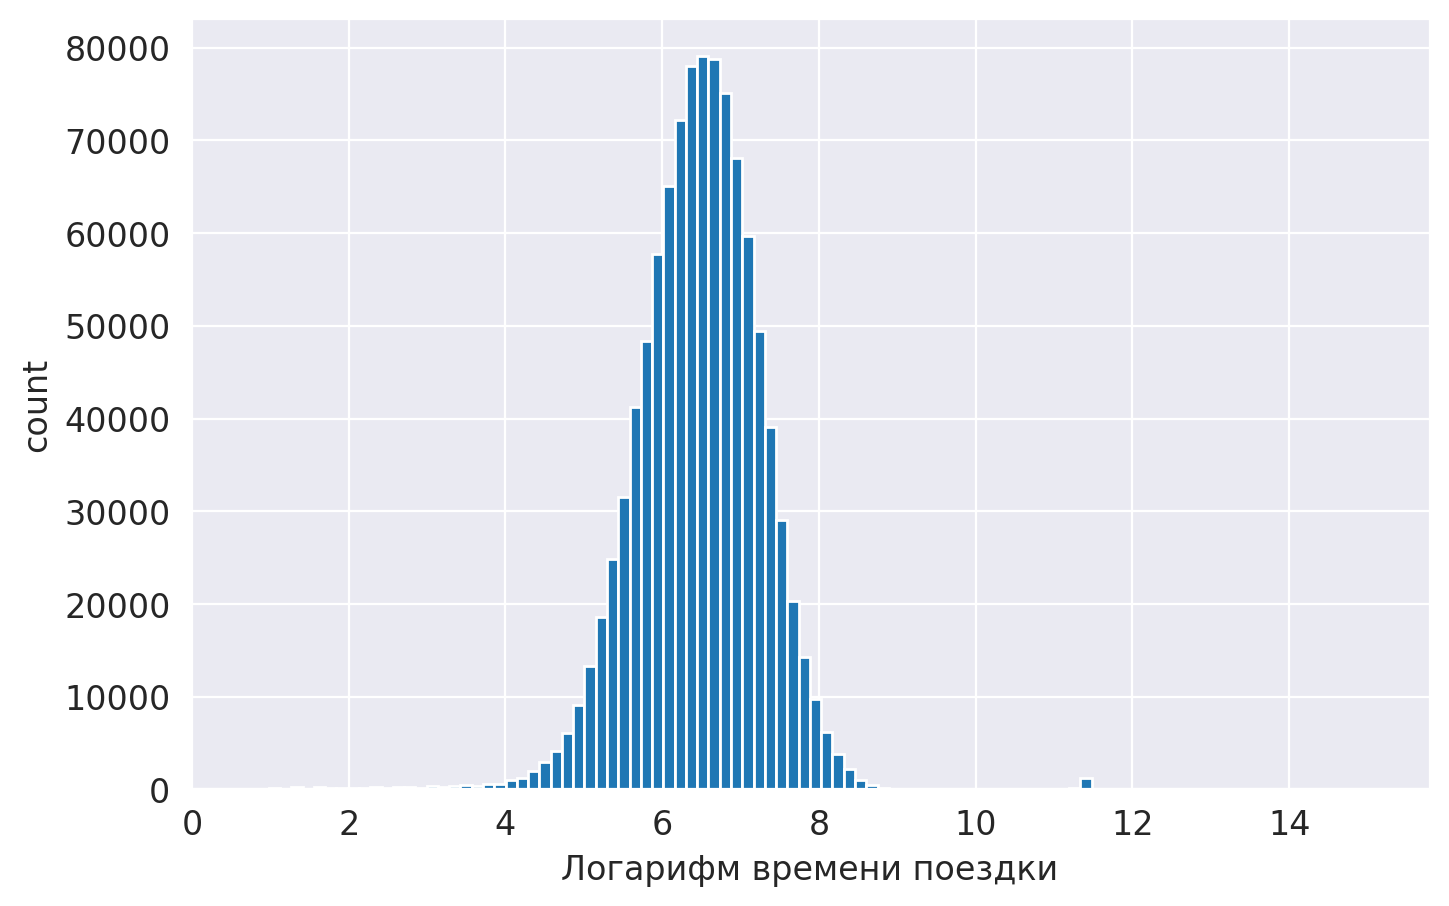

In [74]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(X_train['log_trip_duration'].values, bins=100)
plt.xlabel('Логарифм времени поездки')
plt.ylabel('count')
plt.show()

In [75]:
# удалим поездки, продолжительность которых меньше минуты
X_train = X_train.drop(X_train[np.exp(X_train['log_trip_duration']) - 1 <= 60].index)

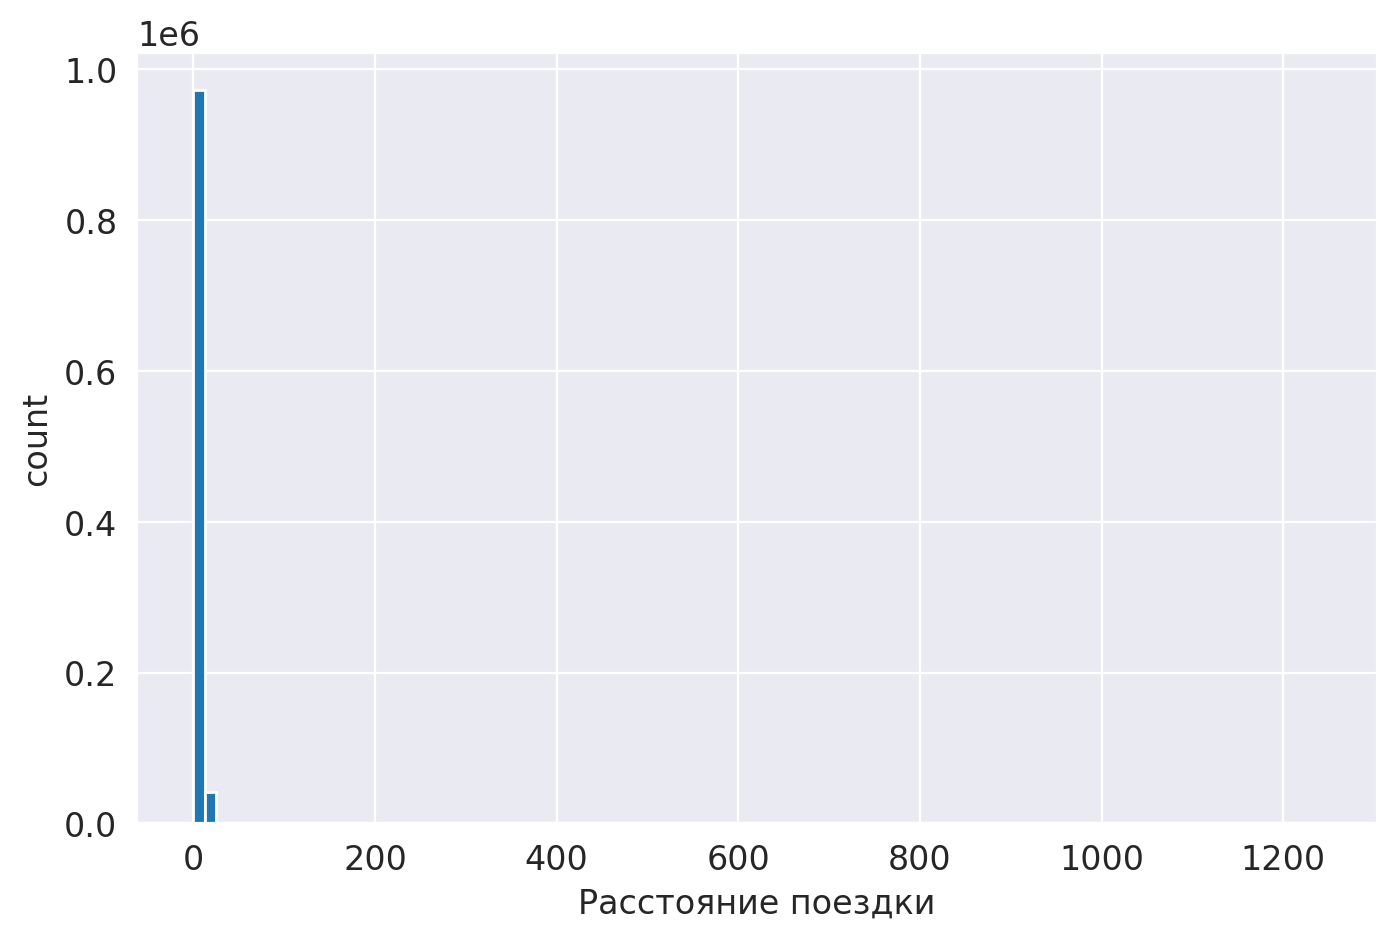

In [76]:
plt.hist(X_train['haversine'].values, bins=100)
plt.xlabel('Расстояние поездки')
plt.ylabel('count')
plt.show()

In [77]:
X_train = X_train.drop(X_train[X_train['haversine'] >= 40].index) # удалим поездки, расстояние которых больше 40 км

In [78]:
X_train

pickup_datetime  pickup_longitude  pickup_latitude  \
824746  2016-03-27 00:25:29        -73.996986        40.742210   
645821  2016-03-18 20:44:12        -73.989929        40.741760   
691846  2016-04-15 18:26:12        -73.972366        40.750725   
1147931 2016-03-24 14:28:34        -73.982361        40.776901   
183569  2016-04-28 13:53:52        -73.973778        40.764374   
...                     ...               ...              ...   
1348317 2016-05-12 05:16:06        -73.996178        40.748222   
1154171 2016-01-16 19:14:54        -73.995415        40.728886   
617841  2016-03-21 20:11:12        -73.960091        40.779701   
1048548 2016-04-09 09:21:44        -73.968124        40.799923   
1393929 2016-04-27 09:11:19        -74.004715        40.707268   

         dropoff_longitude  dropoff_latitude  log_trip_duration  day_of_week  \
824746          -73.987740         40.710659           7.134891            6   
645821          -73.977280         40.783600           6.878326            4   
691846          -73.861832         40.768387           7.642524            4   
1147931         -73.975128         40.760921           6.888572            3   
183569          -73.966957         40.761024           6.177944            3   
...                    ...               ...                ...          ...   
1348317         -73.990967         40.755478           5.198497            3   
1154171         -73.993706         40.744068           8.787678            5   
617841          -73.960136         40.773102           5.023881            0   
1048548         -73.952415         40.818588           6.079933            5   
1393929         -74.014168         40.713989           7.148346            2   

         hour  day_of_year  month  first_anomaly_period  \
824746      0           87      3                   0.0   
645821     20           78      3                   0.0   
691846     18          106      4                   0.0   
1147931    14           84      3                   0.0   
183569     13          119      4                   0.0   
...       ...          ...    ...                   ...   
1348317     5          133      5                   0.0   
1154171    19           16      1                   0.0   
617841     20           81      3                   0.0   
1048548     9          100      4                   0.0   
1393929     9          118      4                   0.0   

         second_anomaly_period  haversine  log_haversine  free_roads  \
824746                     0.0   3.593840       1.524716           0   
645821                     0.0   4.772773       1.753153           0   
691846                     0.0   9.514706       2.352775           0   
1147931                    0.0   1.878364       1.057222           0   
183569                     0.0   0.684609       0.521533           0   
...                        ...        ...            ...         ...   
1348317                    0.0   0.918456       0.651521           1   
1154171                    0.0   1.694346       0.991155           0   
617841                     0.0   0.733833       0.550334           0   
1048548                    0.0   2.460812       1.241503           0   
1393929                    0.0   1.092435       0.738329           0   

         traffic_jams  pickup_jfk  dropoff_jfk  pickup_lga  dropoff_lga  
824746              0           0            0           0            0  
645821              0           0            0           0            0  
691846              0           0            0           0            1  
1147931             1           0            0           0            0  
183569              1           0            0           0            0  
...               ...         ...          ...         ...          ...  
1348317             0           0            0           0            0  
1154171             0           0            0           0            0  
617841            

Так как мы удалили 3 признака: vendor_id, passenger_count, store_and_fwd_flag, то возьмем предпоследнюю регрессию.

<ipython-input-79-602138ae7670>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


<Axes: xlabel='log_trip_duration', ylabel='Density'>

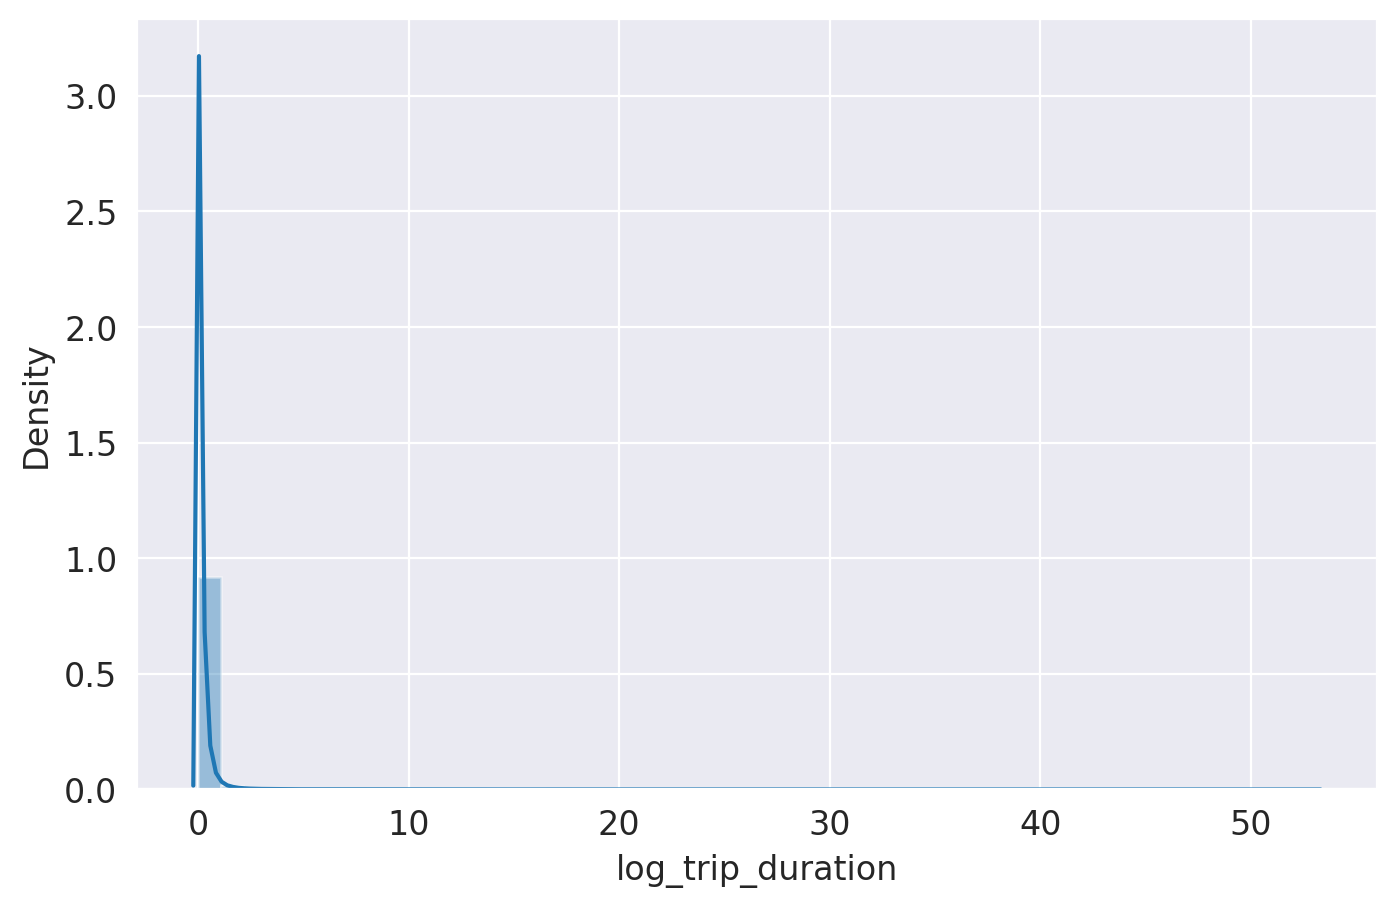

In [79]:
categorical = ['day_of_week', 'hour', 'day_of_year', 'month', 'first_anomaly_period', 'second_anomaly_period', 'free_roads', 'traffic_jams', 'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga', 'pickup_cell', 'dropoff_cell']
numeric_features = ['log_haversine']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_transformed_new, y_train)
y_pred = model.predict(X_test_transformed_new)

error = (y_pred - y_test) ** 2
sns.distplot(error)

Не успеваю доделать, но надо выбрать элементы с огромной ошибкой и удалить их из X_train (избавимся от выбросов тогда).

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сохраните наилучшее значение, как бенчмарк на будущее

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
best_rmsle = ...

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

Времени мало осталось, без картинки 😓